# Starbucks Capstone Challenge

## Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

*The project goal* is to combine transaction, demographic and offer data to **determine which demographic groups respond best to which offer type**. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


# A. Project Deliverables 

1. Identify which groups of people are most responsive to each type of offer  
2. What type offers really excite people?
3. How best to present each type of offer?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, OPTICS
from yellowbrick.cluster.elbow import kelbow_visualizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, plot_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix 

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from pandas_profiling import ProfileReport

import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

# B. Data Wrangling 

## B1. Import data sets

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
# offers portfolio
portfolio.head()

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7

In [4]:
# customers profiles
profile.head()

gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

In [5]:
# records of transactions
transcript.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0

**Note**
- profile and transcript share: user (id and person)
- portfolio and transcript share: offer id

**Action**
- create dummy variables where data type is complicated 
- rename columns for simplifying and merging purposes
- change data types where applicable (e.g. time in days)

## B2. Portfolio

In [6]:
portfolio

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
7       0       [email, mobile, social]           0         3  informational   
8       5  [web, email, mobile, social]           5         5           bogo   
9       2          [web, email, mobile]          10         7       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  
5  2298d6c36e964ae4a3e7e9706d1fb8c2  
6  fafdcd668e3743c1bb461111dcafc2a4  
7  5a8bc65990b245e5a138643cd4eb9837  
8  f19421c1d4aa40978ebb69ca19b0e20d  
9  2906b810c7d4411798c6938adc9daaa5

In [7]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [8]:
portfolio.describe()

reward  difficulty   duration
count  10.000000   10.000000  10.000000
mean    4.200000    7.700000   6.500000
std     3.583915    5.831905   2.321398
min     0.000000    0.000000   3.000000
25%     2.000000    5.000000   5.000000
50%     4.000000    8.500000   7.000000
75%     5.000000   10.000000   7.000000
max    10.000000   20.000000  10.000000

**Note**
- There are 10 unique offer ids, associating with 3 types of offers
- rename the 'id' column to 'offer_id'
- dummy 'channels' and 'offer_type' columns

In [9]:
# change id column name to offer_id
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

# dummy the channels column
channel_dummies = pd.get_dummies(portfolio['channels'].apply(pd.Series).stack(), prefix='channel').sum(level=0)

# drop the orignial channel column and concatenate the dummies ones
portfolio = pd.concat([portfolio,channel_dummies],axis=1)
portfolio.drop('channels', axis=1, inplace=True)

# dummy the offer_type column
offer_dummy = pd.get_dummies(portfolio['offer_type'])

# concatenate back to 'portfolio' df
portfolio = pd.concat([portfolio,offer_dummy],axis=1)

portfolio

reward  difficulty  duration     offer_type  \
0      10          10         7           bogo   
1      10          10         5           bogo   
2       0           0         4  informational   
3       5           5         7           bogo   
4       5          20        10       discount   
5       3           7         7       discount   
6       2          10        10       discount   
7       0           0         3  informational   
8       5           5         5           bogo   
9       2          10         7       discount   

                           offer_id  channel_email  channel_mobile  \
0  ae264e3637204a6fb9bb56bc8210ddfd              1               1   
1  4d5c57ea9a6940dd891ad53e9dbe8da0              1               1   
2  3f207df678b143eea3cee63160fa8bed              1               1   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9              1               1   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7              1               0   
5  2298d6c36e964ae4a3e7e9706d1fb8c2              1               1   
6  fafdcd668e3743c1bb461111dcafc2a4              1               1   
7  5a8bc65990b245e5a138643cd4eb9837              1               1   
8  f19421c1d4aa40978ebb69ca19b0e20d              1               1   
9  2906b810c7d4411798c6938adc9daaa5              1               1   

   channel_social  channel_web  bogo  discount  informational  
0               1            0     1         0              0  
1               1            1     1         0              0  
2               0            1     0         0              1  
3               0            1     1         0              0  
4               0            1     0         1              0  
5               1            1     0         1              0  
6               1            1     0         1              0  
7               1            0     0         0              1  
8               1            1     1         0              0  
9               0            1     0         1              0

In [10]:
print('Types of offers:',portfolio['offer_type'].unique())
print('Numbers of unique offer ids:',portfolio['offer_id'].nunique())
print('Types of advertising channels: email, mobile, social, web')

Types of offers: ['bogo' 'informational' 'discount']
Numbers of unique offer ids: 10
Types of advertising channels: email, mobile, social, web


## B2. Profile

In [11]:
profile.head()

gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

In [12]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

<AxesSubplot:>

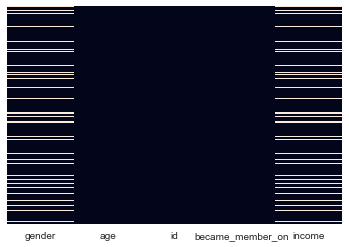

In [13]:
sns.heatmap(profile.isnull(),yticklabels=False,cbar=False)

**__ Insights __**
- rename 'id' to'customer id'
- the same incomplete profiles are missing 'gender' and 'income' info
    - can compute 'income' relative to age range
    - can compute 'gender' into M/F/Unspecified -> dummy
- age: max is 118
    - explore the values, then replace irregular values with appropriate values
    - can group the age into different buckets
- convert 'became_member_on' to date format
    - also consider if year is informative enough -> dummy

### B2.a. Time joined the app

In [14]:
# rename 'id' to 'customer_id'
profile.rename(columns={'id':'customer_id'},inplace=True)

# convert date format
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

profile.head()

gender  age                       customer_id became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5       2018-07-12       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43       2017-08-04       NaN

### B2.b. Gender

In [15]:
# gender values
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [16]:
# fill missing values with 'unspecified'
profile['gender'] = profile['gender'].fillna('Unspecified')

profile.head()

gender  age                       customer_id became_member_on  \
0  Unspecified  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12   
1            F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15   
2  Unspecified  118  38fe809add3b4fcf9315a9694bb96ff5       2018-07-12   
3            F   75  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09   
4  Unspecified  118  a03223e636434f42ac4c3df47e8bac43       2017-08-04   

     income  
0       NaN  
1  112000.0  
2       NaN  
3  100000.0  
4       NaN

In [17]:
profile['gender'].value_counts()

M              8484
F              6129
Unspecified    2175
O               212
Name: gender, dtype: int64

In [18]:
gender = pd.get_dummies(profile['gender'])
gender.head()

F  M  O  Unspecified
0  0  0  0            1
1  1  0  0            0
2  0  0  0            1
3  1  0  0            0
4  0  0  0            1

In [19]:
profile = pd.concat([profile, gender],axis=1)
profile.head()

gender  age                       customer_id became_member_on  \
0  Unspecified  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12   
1            F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15   
2  Unspecified  118  38fe809add3b4fcf9315a9694bb96ff5       2018-07-12   
3            F   75  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09   
4  Unspecified  118  a03223e636434f42ac4c3df47e8bac43       2017-08-04   

     income  F  M  O  Unspecified  
0       NaN  0  0  0            1  
1  112000.0  1  0  0            0  
2       NaN  0  0  0            1  
3  100000.0  1  0  0            0  
4       NaN  0  0  0            1

### B2.c. Age and Income

In [20]:
# Age stats
profile['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

In [21]:
# number of unique age
profile['age'].nunique()

85

In [22]:
# unique age
profile['age'].unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99])

In [23]:
profile['age'].value_counts().sort_index()

18       70
19      135
20      135
21      140
22      131
       ... 
98        5
99        5
100      12
101       5
118    2175
Name: age, Length: 85, dtype: int64

<AxesSubplot:xlabel='age', ylabel='Density'>

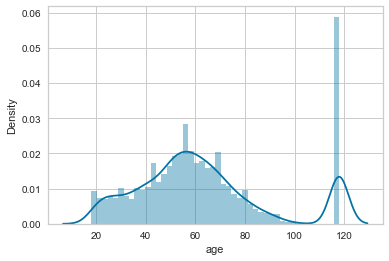

In [24]:
# Distribution of customer age
sns.distplot(profile['age'])

<AxesSubplot:xlabel='income', ylabel='Density'>

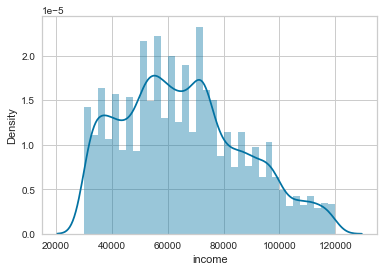

In [25]:
# Income distribution
sns.distplot(profile['income'])

**__ Insights __**
- Can I consider age of 100, 101 and 118 are abnormal and drop them as outliers from analysis? 
- Outlier rule of thumb is >3 std. 3std in age distribution: 3(26.74) = 80.22
- From income stats, the saraly min is 30K, max is 120K, average is 64K. It is reasonable to use the average income to compute for mising values.
- However, are the missing values associated with users who are older than 100 years old?

### B2.d. Abnormal age

In [26]:
abnorm_age = [100,101,118]
abnorm = profile[profile['age'].isin(abnorm_age)]

print(abnorm.shape)
abnorm.head()

(2192, 9)


gender  age                       customer_id became_member_on  \
0  Unspecified  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12   
2  Unspecified  118  38fe809add3b4fcf9315a9694bb96ff5       2018-07-12   
4  Unspecified  118  a03223e636434f42ac4c3df47e8bac43       2017-08-04   
6  Unspecified  118  8ec6ce2a7e7949b1bf142def7d0e0586       2017-09-25   
7  Unspecified  118  68617ca6246f4fbc85e91a2a49552598       2017-10-02   

   income  F  M  O  Unspecified  
0     NaN  0  0  0            1  
2     NaN  0  0  0            1  
4     NaN  0  0  0            1  
6     NaN  0  0  0            1  
7     NaN  0  0  0            1

In [27]:
# portion of abnormal age in the dataset
abnorm.shape[0]/profile.shape[0]

0.12894117647058823

In [28]:
abnorm.groupby(['age','income']).count()

gender  customer_id  became_member_on  F  M  O  Unspecified
age income                                                               
100 42000.0        1            1                 1  1  1  1            1
    47000.0        1            1                 1  1  1  1            1
    63000.0        2            2                 2  2  2  2            2
    70000.0        1            1                 1  1  1  1            1
    71000.0        2            2                 2  2  2  2            2
    83000.0        1            1                 1  1  1  1            1
    96000.0        1            1                 1  1  1  1            1
    98000.0        1            1                 1  1  1  1            1
    109000.0       1            1                 1  1  1  1            1
    118000.0       1            1                 1  1  1  1            1
101 43000.0        1            1                 1  1  1  1            1
    56000.0        1            1                 1  1  1  1            1
    59000.0        1            1                 1  1  1  1            1
    82000.0        1            1                 1  1  1  1            1
    99000.0        1            1                 1  1  1  1            1

In [29]:
abnorm['income'].nunique()

15

**Questions:** 
- are all 118-yr users don't have income?
- are all NaN income from profile df associates with 118-yr users?
- what is the percentage of 118-yr user in the df?

<AxesSubplot:>

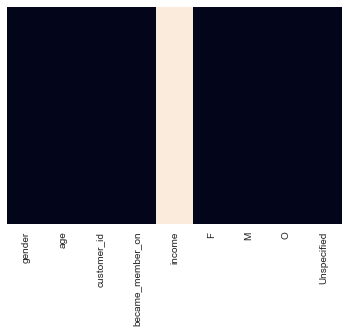

In [30]:
# yes, all 118-yr users don't have income
sns.heatmap(abnorm.query('age == 118').isnull(),yticklabels=False,cbar=False)

# or profile[profile['age'] == 118]

In [31]:
# total 118-yr users
abnorm['age'].value_counts() # agreed with profile df

118    2175
100      12
101       5
Name: age, dtype: int64

In [32]:
# total nul values for income
abnorm['income'].isnull().sum() # agreed with profile df

2175

In [33]:
# what about their gender?
abnorm.groupby(['age','gender']).count() # agreed with profile df

customer_id  became_member_on  income     F     M     O  \
age gender                                                                 
100 F                      9                 9       9     9     9     9   
    M                      2                 2       2     2     2     2   
    O                      1                 1       1     1     1     1   
101 F                      5                 5       5     5     5     5   
118 Unspecified         2175              2175       0  2175  2175  2175   

                 Unspecified  
age gender                    
100 F                      9  
    M                      2  
    O                      1  
101 F                      5  
118 Unspecified         2175

In [34]:
# Portion of 118-yr users
percent118 = len(profile[profile['age']==118])/profile.shape[0]*100
percent118

12.794117647058822

### B2.e. Findings on Profile dataset

In [35]:
print('There are {} users who are 118 years old.'.format(abnorm['age'].value_counts()[118]))
print('There are {} users who do not provide income.'.format(profile['income'].isnull().sum()))
print('There are {} users who do not provide gender.'.format(abnorm[abnorm['gender']=='Unspecified'].shape[0]))
print('Percentage of people whose age is 118 is: {}%'.format(round(percent118,2)))
print('Percentage of people who is older than 100 is: {}%'.format(round(abnorm.shape[0]/profile.shape[0]*100, 2)))

There are 2175 users who are 118 years old.
There are 2175 users who do not provide income.
There are 2175 users who do not provide gender.
Percentage of people whose age is 118 is: 12.79%
Percentage of people who is older than 100 is: 12.89%


After exploring the data, I conclude that the abnormal users have these attributes:
- 118 years old 
- don't have income
- gender is unspecified

I consider all users who are older than 100 years old as outliers since these ages are greater than 3 std.dev in age distribution, and there is not a significant amount difference (0.10%) of 118-yr vs greater than 100-yr sample sizes. Therefore, 
- I'm not going to compute missing income
- I'm going to remove them from the data set later after merging all data sets

## B3. Transcript

Data description
- person: (string/hash)
- event: (string) offer received, offer viewed, transaction, offer completed
- value: (dictionary) different values depending on event type
- offer id: (string/hash) not associated with any "transaction"
- amount: (numeric) money spent in "transaction"
- reward: (numeric) money gained from "offer completed"
- time: (numeric) hours after start of test

In [36]:
transcript.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0

In [37]:
transcript.describe()

time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.000000
max       714.000000

In [38]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


**Note**
- rename 'person' to 'customer_id'
- convert time from hour to day
- dummy 'event' and 'value' 

### B3.a. Time

In [39]:
# rename 'person' to 'customer_id'
transcript.rename(columns={'person':'customer_id'},inplace=True)

# convert time
transcript['day'] = transcript['time'].apply(lambda x: int(x / 24) + (x % 24 > 0))
transcript.drop('time',axis=1,inplace=True)

transcript

customer_id           event  \
0       78afa995795e4d85b5d9ceeca43f5fef  offer received   
1       a03223e636434f42ac4c3df47e8bac43  offer received   
2       e2127556f4f64592b11af22de27a7932  offer received   
3       8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4       68617ca6246f4fbc85e91a2a49552598  offer received   
...                                  ...             ...   
306529  b3a1272bc9904337b331bf348c3e8c17     transaction   
306530  68213b08d99a4ae1b0dcb72aebd9aa35     transaction   
306531  a00058cf10334a308c68e7631c529907     transaction   
306532  76ddbd6576844afe811f1a3c0fbb5bec     transaction   
306533  c02b10e8752c4d8e9b73f918558531f7     transaction   

                                                   value  day  
0       {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}    0  
1       {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}    0  
2       {'offer id': '2906b810c7d4411798c6938adc9daaa5'}    0  
3       {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}    0  
4       {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}    0  
...                                                  ...  ...  
306529                    {'amount': 1.5899999999999999}   30  
306530                                  {'amount': 9.53}   30  
306531                                  {'amount': 3.61}   30  
306532                    {'amount': 3.5300000000000002}   30  
306533                                  {'amount': 4.05}   30  

[306534 rows x 4 columns]

<AxesSubplot:xlabel='day', ylabel='Density'>

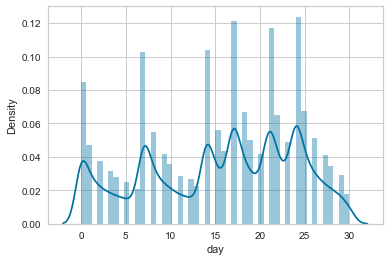

In [40]:
# time distribution
sns.distplot(transcript['day'])

### B3.b. Event

In [41]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

How does each evennt's entry look like?

In [42]:
# offer received
transcript.query('event == "offer received"').head()

customer_id           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  day  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}    0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}    0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}    0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}    0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}    0

In [43]:
# offer viewed
transcript.query('event == "offer viewed"').head()

customer_id         event  \
12650  389bc3fa690240e798340f5a15918d5c  offer viewed   
12651  d1ede868e29245ea91818a903fec04c6  offer viewed   
12652  102e9454054946fda62242d2e176fdce  offer viewed   
12653  02c083884c7d45b39cc68e1314fec56c  offer viewed   
12655  be8a5d1981a2458d90b255ddc7e0d174  offer viewed   

                                                  value  day  
12650  {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}    0  
12651  {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}    0  
12652  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}    0  
12653  {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}    0  
12655  {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}    0

In [44]:
# offer completed
transcript.query('event == "offer completed"').head()

customer_id            event  \
12658  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f  offer completed   
12672  fe97aa22dd3e48c8b143116a8403dd52  offer completed   
12679  629fc02d56414d91bca360decdfa9288  offer completed   
12692  676506bad68e4161b9bbaffeb039626b  offer completed   
12697  8f7dd3b2afe14c078eb4f6e6fe4ba97d  offer completed   

                                                   value  day  
12658  {'offer_id': '2906b810c7d4411798c6938adc9daaa5...    0  
12672  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...    0  
12679  {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...    0  
12692  {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...    0  
12697  {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...    0

In [45]:
# In offer completed, the value column seems to contain lengthy value
transcript[transcript['event']=='offer completed']['value'][12658]

{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}

In [46]:
# transaction
transcript.query('event == "transaction"').head()

customer_id        event  \
12654  02c083884c7d45b39cc68e1314fec56c  transaction   
12657  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f  transaction   
12659  54890f68699049c2a04d415abc25e717  transaction   
12670  b2f1cd155b864803ad8334cdf13c4bd2  transaction   
12671  fe97aa22dd3e48c8b143116a8403dd52  transaction   

                                value  day  
12654  {'amount': 0.8300000000000001}    0  
12657               {'amount': 34.56}    0  
12659               {'amount': 13.23}    0  
12670               {'amount': 19.51}    0  
12671               {'amount': 18.97}    0

**Insights**
- For "received and viewed" envents, there are only offer id.
    - E.g: {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
- For "completed" event, there are record of the offer id and its value (dollars). Note the underscore **"offer_id"**
    - E.g.: {'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}
- For "transaction" event, there is record of the amount spent (dollars)
    - E.g: {'amount': 34.56}

### B3.c. Value: {'offer' : 'offer value'}

In [47]:
transcript['value'] # it contains many dictionaries

0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

In [48]:
# What are the keys of 'offer'? 
def uniqueKeys(arr):
    key = list(set(key for dic in arr for key in dic.keys()))
    return key

uniqueKeys(transcript['value'])

['amount', 'offer_id', 'offer id', 'reward']

**Note**: 
- each offer_id associates with a reward (see portfolio df), and is "completed" event
- can bypass recording reward at this step because this information can publish by merging with portfolio df later

In [49]:
# create 'offer_id' col
transcript['offer_id'] = [list(x.values())[0]  if (list(x.keys())[0] in ['offer_id', 'offer id']) else np.nan for x in transcript['value']]
# create 'amount' col
transcript['amount'] = [list(x.values())[0]  if (list(x.keys())[0] in ['amount']) else np.nan for x in transcript['value']]

transcript.head()

customer_id           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  day  \
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}    0   
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}    0   
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}    0   
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}    0   
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}    0   

                           offer_id  amount  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN  
2  2906b810c7d4411798c6938adc9daaa5     NaN  
3  fafdcd668e3743c1bb461111dcafc2a4     NaN  
4  4d5c57ea9a6940dd891ad53e9dbe8da0     NaN

In [50]:
# drop the 'value' column
transcript.drop(columns=['value'],inplace=True)
transcript.head()

customer_id           event  day  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received    0   
1  a03223e636434f42ac4c3df47e8bac43  offer received    0   
2  e2127556f4f64592b11af22de27a7932  offer received    0   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received    0   
4  68617ca6246f4fbc85e91a2a49552598  offer received    0   

                           offer_id  amount  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN  
2  2906b810c7d4411798c6938adc9daaa5     NaN  
3  fafdcd668e3743c1bb461111dcafc2a4     NaN  
4  4d5c57ea9a6940dd891ad53e9dbe8da0     NaN

### B3.d. Splitting transactions and offers groups

In [51]:
print(portfolio.shape)
portfolio

(10, 12)


reward  difficulty  duration     offer_type  \
0      10          10         7           bogo   
1      10          10         5           bogo   
2       0           0         4  informational   
3       5           5         7           bogo   
4       5          20        10       discount   
5       3           7         7       discount   
6       2          10        10       discount   
7       0           0         3  informational   
8       5           5         5           bogo   
9       2          10         7       discount   

                           offer_id  channel_email  channel_mobile  \
0  ae264e3637204a6fb9bb56bc8210ddfd              1               1   
1  4d5c57ea9a6940dd891ad53e9dbe8da0              1               1   
2  3f207df678b143eea3cee63160fa8bed              1               1   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9              1               1   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7              1               0   
5  2298d6c36e964ae4a3e7e9706d1fb8c2              1               1   
6  fafdcd668e3743c1bb461111dcafc2a4              1               1   
7  5a8bc65990b245e5a138643cd4eb9837              1               1   
8  f19421c1d4aa40978ebb69ca19b0e20d              1               1   
9  2906b810c7d4411798c6938adc9daaa5              1               1   

   channel_social  channel_web  bogo  discount  informational  
0               1            0     1         0              0  
1               1            1     1         0              0  
2               0            1     0         0              1  
3               0            1     1         0              0  
4               0            1     0         1              0  
5               1            1     0         1              0  
6               1            1     0         1              0  
7               1            0     0         0              1  
8               1            1     1         0              0  
9               0            1     0         1              0

In [52]:
print(profile.shape)
profile.head()

(17000, 9)


gender  age                       customer_id became_member_on  \
0  Unspecified  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12   
1            F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15   
2  Unspecified  118  38fe809add3b4fcf9315a9694bb96ff5       2018-07-12   
3            F   75  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09   
4  Unspecified  118  a03223e636434f42ac4c3df47e8bac43       2017-08-04   

     income  F  M  O  Unspecified  
0       NaN  0  0  0            1  
1  112000.0  1  0  0            0  
2       NaN  0  0  0            1  
3  100000.0  1  0  0            0  
4       NaN  0  0  0            1

In [53]:
print(transcript.shape)
transcript.head()

(306534, 5)


customer_id           event  day  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received    0   
1  a03223e636434f42ac4c3df47e8bac43  offer received    0   
2  e2127556f4f64592b11af22de27a7932  offer received    0   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received    0   
4  68617ca6246f4fbc85e91a2a49552598  offer received    0   

                           offer_id  amount  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN  
2  2906b810c7d4411798c6938adc9daaa5     NaN  
3  fafdcd668e3743c1bb461111dcafc2a4     NaN  
4  4d5c57ea9a6940dd891ad53e9dbe8da0     NaN

### Transactions group

In [54]:
# query transaction event
transactions = transcript.query('event == "transaction"').copy()
transactions.head()

customer_id        event  day offer_id  amount
12654  02c083884c7d45b39cc68e1314fec56c  transaction    0      NaN    0.83
12657  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f  transaction    0      NaN   34.56
12659  54890f68699049c2a04d415abc25e717  transaction    0      NaN   13.23
12670  b2f1cd155b864803ad8334cdf13c4bd2  transaction    0      NaN   19.51
12671  fe97aa22dd3e48c8b143116a8403dd52  transaction    0      NaN   18.97

In [55]:
# merge with profile df on 'customer_id'
transactions = transactions.merge(profile, left_on='customer_id', right_on='customer_id')

# remove abnormal age 
transactions = transactions.query('age < 100')

# drop 'event', 'offer_id', and 'Unspecified' gender 
transactions.drop(['event','offer_id', 'Unspecified'],axis=1, inplace=True)

print(transactions.shape)
transactions.head()

(123802, 10)


customer_id  day  amount gender  age became_member_on  \
0  02c083884c7d45b39cc68e1314fec56c    0    0.83      F   20       2016-07-11   
1  02c083884c7d45b39cc68e1314fec56c    1    1.44      F   20       2016-07-11   
2  02c083884c7d45b39cc68e1314fec56c    1    4.56      F   20       2016-07-11   
3  02c083884c7d45b39cc68e1314fec56c    4    1.53      F   20       2016-07-11   
4  02c083884c7d45b39cc68e1314fec56c    4    0.50      F   20       2016-07-11   

    income  F  M  O  
0  30000.0  1  0  0  
1  30000.0  1  0  0  
2  30000.0  1  0  0  
3  30000.0  1  0  0  
4  30000.0  1  0  0

### Offers group

In [56]:
# query offers event
offers = transcript.query('event != "transaction"').copy()

offers.head()

customer_id           event  day  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received    0   
1  a03223e636434f42ac4c3df47e8bac43  offer received    0   
2  e2127556f4f64592b11af22de27a7932  offer received    0   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received    0   
4  68617ca6246f4fbc85e91a2a49552598  offer received    0   

                           offer_id  amount  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN  
2  2906b810c7d4411798c6938adc9daaa5     NaN  
3  fafdcd668e3743c1bb461111dcafc2a4     NaN  
4  4d5c57ea9a6940dd891ad53e9dbe8da0     NaN

In [57]:
# merge with profile df on 'customer_id'
offers = offers.merge(profile, left_on='customer_id', right_on='customer_id')
# merge with portfolio df on 'offer_id'
offers = offers.merge(portfolio, left_on='offer_id', right_on='offer_id')

# remove abnormal age 
offers = offers.query('age < 100')

# drop 'amount' and 'Unspecified' gender
offers.drop(['amount', 'Unspecified'],axis=1, inplace=True)

print(offers.shape)
offers.head()

(148628, 22)


customer_id            event  day  \
0  78afa995795e4d85b5d9ceeca43f5fef   offer received    0   
1  78afa995795e4d85b5d9ceeca43f5fef     offer viewed    1   
2  78afa995795e4d85b5d9ceeca43f5fef  offer completed    6   
3  e2127556f4f64592b11af22de27a7932   offer received   17   
4  e2127556f4f64592b11af22de27a7932     offer viewed   18   

                           offer_id gender  age became_member_on    income  F  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75       2017-05-09  100000.0  1   
1  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75       2017-05-09  100000.0  1   
2  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75       2017-05-09  100000.0  1   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9      M   68       2018-04-26   70000.0  0   
4  9b98b8c7a33c4b65b9aebfe6a799e6d9      M   68       2018-04-26   70000.0  0   

   M  ...  difficulty  duration  offer_type  channel_email channel_mobile  \
0  0  ...           5         7        bogo              1              1   
1  0  ...           5         7        bogo              1              1   
2  0  ...           5         7        bogo              1              1   
3  1  ...           5         7        bogo              1              1   
4  1  ...           5         7        bogo              1              1   

   channel_social  channel_web  bogo  discount  informational  
0               0            1     1         0              0  
1               0            1     1         0              0  
2               0            1     1         0              0  
3               0            1     1         0              0  
4               0            1     1         0              0  

[5 rows x 22 columns]

In [58]:
print('Numbers of entries in Transactions dataset:',transactions.shape[0])
print('Numbers of unique customers in Transactions dataset',transactions['customer_id'].nunique())
print('\nNumbers of entries in Offers dataset:',offers.shape[0])
print('Numbers of unique customers in Offers dataset',offers['customer_id'].nunique())

Numbers of entries in Transactions dataset: 123802
Numbers of unique customers in Transactions dataset 14475

Numbers of entries in Offers dataset: 148628
Numbers of unique customers in Offers dataset 14803


In [59]:
# merge the 2 dataframes
off_tran = offers.merge(transactions,on='customer_id', how='outer')

print(off_tran.shape)
off_tran.head()

(1329671, 31)


customer_id           event  day_x  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received    0.0   
1  78afa995795e4d85b5d9ceeca43f5fef  offer received    0.0   
2  78afa995795e4d85b5d9ceeca43f5fef  offer received    0.0   
3  78afa995795e4d85b5d9ceeca43f5fef  offer received    0.0   
4  78afa995795e4d85b5d9ceeca43f5fef  offer received    0.0   

                           offer_id gender_x  age_x became_member_on_x  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9        F   75.0         2017-05-09   
1  9b98b8c7a33c4b65b9aebfe6a799e6d9        F   75.0         2017-05-09   
2  9b98b8c7a33c4b65b9aebfe6a799e6d9        F   75.0         2017-05-09   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9        F   75.0         2017-05-09   
4  9b98b8c7a33c4b65b9aebfe6a799e6d9        F   75.0         2017-05-09   

   income_x  F_x  M_x  ...  informational  day_y  amount  gender_y age_y  \
0  100000.0  1.0  0.0  ...            0.0    6.0   19.89         F  75.0   
1  100000.0  1.0  0.0  ...            0.0    6.0   17.78         F  75.0   
2  100000.0  1.0  0.0  ...            0.0   10.0   19.67         F  75.0   
3  100000.0  1.0  0.0  ...            0.0   10.0   29.72         F  75.0   
4  100000.0  1.0  0.0  ...            0.0   16.0   23.93         F  75.0   

   became_member_on_y  income_y  F_y  M_y  O_y  
0          2017-05-09  100000.0  1.0  0.0  0.0  
1          2017-05-09  100000.0  1.0  0.0  0.0  
2          2017-05-09  100000.0  1.0  0.0  0.0  
3          2017-05-09  100000.0  1.0  0.0  0.0  
4          2017-05-09  100000.0  1.0  0.0  0.0  

[5 rows x 31 columns]

In [60]:
off_tran['customer_id'].nunique()

14808

In [61]:
trans_cust = transactions['customer_id'].unique()
offers_cust = offers['customer_id'].unique()

In [62]:
# Do all customers making purchases receive offers?
trans_in_offers = np.isin(trans_cust,offers_cust)
ar_unique, i = np.unique(trans_in_offers, return_counts=True)
print(ar_unique)
print(i)

[False  True]
[    5 14470]


In [63]:
# Do all customers receiveing offers make purchases?
offers_in_trans = np.isin(offers_cust,trans_cust)
ar_unique1, i1 = np.unique(offers_in_trans, return_counts=True)

print(ar_unique1)
print(i1)

[False  True]
[  333 14470]


**__ Insights __**
- There are 5 customers purchased without ever receiving offers
- There are 333 customers received offers but didn't make any purchases 

This makes senses because there are **14803 customers received offers**, and **5 customers never receive offers** but make purchases. So totally there are **14808 unique customers**.

## Thoughts Process for Analysis

The numbers of unique customers in the 3 dataframes above indicate that there are **14808 customers in this test**. They make purchases either after interacting (receive, view, complete) with promotional offers or without knowledge of offers. 

Therefore, I need to do some more data wrangling to *remove duplicates* and *consolidate* all the information to a final dataframe. **This dataframe will contain unique customers, their information, their associated purchases, and offers interactions if any.** 

1. Transactions group:
    - Have amount spent
    - Do not have offer_id, offer_type, or rewards
    - Records of customers making purchases with or without using offers
    - Can study the group spending habit and demographic <br>

2. Offers group:
    - Compute view_rate 
    - Compute complete_rate
    - Compute conversion_rate: view then complete
    - How these rates correlates with customers' demographic ?
    - How conversion rate is impacted by the type of offer, offer's source ? 

**Recall project deliveriables**
- customer segmentations
- types of offers that work when intergrating with customers' demographics
- is there a model to predict which customer should receive offers?

## B4. Data Wrangling (cont.)

### B4.a. Transactions group

In [64]:
transactions.head()

customer_id  day  amount gender  age became_member_on  \
0  02c083884c7d45b39cc68e1314fec56c    0    0.83      F   20       2016-07-11   
1  02c083884c7d45b39cc68e1314fec56c    1    1.44      F   20       2016-07-11   
2  02c083884c7d45b39cc68e1314fec56c    1    4.56      F   20       2016-07-11   
3  02c083884c7d45b39cc68e1314fec56c    4    1.53      F   20       2016-07-11   
4  02c083884c7d45b39cc68e1314fec56c    4    0.50      F   20       2016-07-11   

    income  F  M  O  
0  30000.0  1  0  0  
1  30000.0  1  0  0  
2  30000.0  1  0  0  
3  30000.0  1  0  0  
4  30000.0  1  0  0

**Note**
1. time (int) - time in hours since start of test. The data begins at time t=0 -> Change name to 'day'
2. Frequency: how many times the customers make purchases
3. Recency: the 'day' column represents number of days after the test starts (t=0). 
    - Recency of purchase will the be most recent day (aka the max days after t0)
4. Monetary value: total amount a customer spent

In [65]:
transactions[transactions.duplicated('customer_id')].head(10)

customer_id  day  amount gender  age  \
1   02c083884c7d45b39cc68e1314fec56c    1    1.44      F   20   
2   02c083884c7d45b39cc68e1314fec56c    1    4.56      F   20   
3   02c083884c7d45b39cc68e1314fec56c    4    1.53      F   20   
4   02c083884c7d45b39cc68e1314fec56c    4    0.50      F   20   
5   02c083884c7d45b39cc68e1314fec56c    5    9.80      F   20   
6   02c083884c7d45b39cc68e1314fec56c    6    4.10      F   20   
7   02c083884c7d45b39cc68e1314fec56c    6    2.73      F   20   
8   02c083884c7d45b39cc68e1314fec56c    9    1.22      F   20   
9   02c083884c7d45b39cc68e1314fec56c   18    3.18      F   20   
11  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f    2   21.55      M   42   

   became_member_on   income  F  M  O  
1        2016-07-11  30000.0  1  0  0  
2        2016-07-11  30000.0  1  0  0  
3        2016-07-11  30000.0  1  0  0  
4        2016-07-11  30000.0  1  0  0  
5        2016-07-11  30000.0  1  0  0  
6        2016-07-11  30000.0  1  0  0  
7        2016-07-11  30000.0  1  0  0  
8        2016-07-11  30000.0  1  0  0  
9        2016-07-11  30000.0  1  0  0  
11       2016-01-17  96000.0  0  1  0

In [66]:
transactions.groupby(['customer_id']).count()

day  amount  gender  age  became_member_on  \
customer_id                                                                    
0009655768c64bdeb2e877511632db8f    8       8       8    8                 8   
0011e0d4e6b944f998e987f904e8c1e5    5       5       5    5                 5   
0020c2b971eb4e9188eac86d93036a77    8       8       8    8                 8   
0020ccbbb6d84e358d3414a3ff76cffd   12      12      12   12                12   
003d66b6608740288d6cc97a6903f4f0   18      18      18   18                18   
...                               ...     ...     ...  ...               ...   
fff3ba4757bd42088c044ca26d73817a   11      11      11   11                11   
fff7576017104bcc8677a8d63322b5e1    6       6       6    6                 6   
fff8957ea8b240a6b5e634b6ee8eafcf    5       5       5    5                 5   
fffad4f4828548d1b5583907f2e9906b   12      12      12   12                12   
ffff82501cea40309d5fdd7edcca4a07   15      15      15   15                15   

                                  income   F   M   O  
customer_id                                           
0009655768c64bdeb2e877511632db8f       8   8   8   8  
0011e0d4e6b944f998e987f904e8c1e5       5   5   5   5  
0020c2b971eb4e9188eac86d93036a77       8   8   8   8  
0020ccbbb6d84e358d3414a3ff76cffd      12  12  12  12  
003d66b6608740288d6cc97a6903f4f0      18  18  18  18  
...                                  ...  ..  ..  ..  
fff3ba4757bd42088c044ca26d73817a      11  11  11  11  
fff7576017104bcc8677a8d63322b5e1       6   6   6   6  
fff8957ea8b240a6b5e634b6ee8eafcf       5   5   5   5  
fffad4f4828548d1b5583907f2e9906b      12  12  12  12  
ffff82501cea40309d5fdd7edcca4a07      15  15  15  15  

[14475 rows x 9 columns]

**What to expect**: 

A dataframe in which each customer has one entry. This entry contains the customer information, the frequency of making purchase, the most recent time a purchased is made, and a total amount spent so far.

**Action**

Merge the 3 series (frequency, recency, total amount) on customer_id
- compute frequency, recency, total amount. There will be 3 series separately
- drop the duplicated customers from the transactions df
- join all 3 series

In [67]:
# frequency
frequency = transactions.groupby(['customer_id'])['customer_id'].count()
# recency
recency = transactions.groupby(['customer_id'])['day'].max()
# monetary 
monetary = transactions.groupby(['customer_id'])['amount'].sum()

In [68]:
# join recency, frequency, monetary value
rfm = pd.concat([recency,frequency,monetary],axis=1)
rfm.columns = ['recency','frequency','monetary value']
rfm.head()

recency  frequency  monetary value
customer_id                                                         
0009655768c64bdeb2e877511632db8f       29          8          127.60
0011e0d4e6b944f998e987f904e8c1e5       28          5           79.46
0020c2b971eb4e9188eac86d93036a77       30          8          196.86
0020ccbbb6d84e358d3414a3ff76cffd       28         12          154.05
003d66b6608740288d6cc97a6903f4f0       29         18           48.34

In [69]:
# drop the duplicates customers
transactions.drop_duplicates(subset='customer_id',inplace=True)
transactions.shape

(14475, 10)

In [70]:
# drop the original 'day' and 'amount' columns
transactions.drop(['day','amount'],axis=1,inplace=True)

# clean transactions_df
transactions = pd.merge(left=transactions, right=rfm, on='customer_id')
print(transactions.shape)
transactions.head()

(14475, 11)


customer_id gender  age became_member_on   income  F  \
0  02c083884c7d45b39cc68e1314fec56c      F   20       2016-07-11  30000.0  1   
1  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f      M   42       2016-01-17  96000.0  0   
2  54890f68699049c2a04d415abc25e717      M   36       2017-12-28  56000.0  0   
3  b2f1cd155b864803ad8334cdf13c4bd2      F   55       2017-10-16  94000.0  1   
4  fe97aa22dd3e48c8b143116a8403dd52      F   39       2017-12-17  67000.0  1   

   M  O  recency  frequency  monetary value  
0  0  0       18         10           29.89  
1  1  0       23         12          320.48  
2  1  0       29          7          118.85  
3  0  0       24          8          195.35  
4  0  0       30         11          562.77

### B4.b. Offers group

In [71]:
offers.head()

customer_id            event  day  \
0  78afa995795e4d85b5d9ceeca43f5fef   offer received    0   
1  78afa995795e4d85b5d9ceeca43f5fef     offer viewed    1   
2  78afa995795e4d85b5d9ceeca43f5fef  offer completed    6   
3  e2127556f4f64592b11af22de27a7932   offer received   17   
4  e2127556f4f64592b11af22de27a7932     offer viewed   18   

                           offer_id gender  age became_member_on    income  F  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75       2017-05-09  100000.0  1   
1  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75       2017-05-09  100000.0  1   
2  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75       2017-05-09  100000.0  1   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9      M   68       2018-04-26   70000.0  0   
4  9b98b8c7a33c4b65b9aebfe6a799e6d9      M   68       2018-04-26   70000.0  0   

   M  ...  difficulty  duration  offer_type  channel_email channel_mobile  \
0  0  ...           5         7        bogo              1              1   
1  0  ...           5         7        bogo              1              1   
2  0  ...           5         7        bogo              1              1   
3  1  ...           5         7        bogo              1              1   
4  1  ...           5         7        bogo              1              1   

   channel_social  channel_web  bogo  discount  informational  
0               0            1     1         0              0  
1               0            1     1         0              0  
2               0            1     1         0              0  
3               0            1     1         0              0  
4               0            1     1         0              0  

[5 rows x 22 columns]

In [72]:
# the same offer can be received and viewed multiple times
offers[offers.duplicated(subset=['offer_id', 'customer_id'], keep=False)].head()

customer_id            event  day  \
0  78afa995795e4d85b5d9ceeca43f5fef   offer received    0   
1  78afa995795e4d85b5d9ceeca43f5fef     offer viewed    1   
2  78afa995795e4d85b5d9ceeca43f5fef  offer completed    6   
3  e2127556f4f64592b11af22de27a7932   offer received   17   
4  e2127556f4f64592b11af22de27a7932     offer viewed   18   

                           offer_id gender  age became_member_on    income  F  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75       2017-05-09  100000.0  1   
1  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75       2017-05-09  100000.0  1   
2  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75       2017-05-09  100000.0  1   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9      M   68       2018-04-26   70000.0  0   
4  9b98b8c7a33c4b65b9aebfe6a799e6d9      M   68       2018-04-26   70000.0  0   

   M  ...  difficulty  duration  offer_type  channel_email channel_mobile  \
0  0  ...           5         7        bogo              1              1   
1  0  ...           5         7        bogo              1              1   
2  0  ...           5         7        bogo              1              1   
3  1  ...           5         7        bogo              1              1   
4  1  ...           5         7        bogo              1              1   

   channel_social  channel_web  bogo  discount  informational  
0               0            1     1         0              0  
1               0            1     1         0              0  
2               0            1     1         0              0  
3               0            1     1         0              0  
4               0            1     1         0              0  

[5 rows x 22 columns]

**Note**
- a customer can receive the same offer multiple times, and interact accordingly (received, viewed, completed)
- an offer can be received and viewed multiple times by a customer

**Actions**
- Dummy the 'event' column
- Identify duplicates on a subset of customer_id and offer_id

In [73]:
# dummy the 'event' col
event_dummies = pd.get_dummies(offers['event'])
# concatenate to the original df
offers = pd.concat([offers,event_dummies],axis=1)
offers.head()

customer_id            event  day  \
0  78afa995795e4d85b5d9ceeca43f5fef   offer received    0   
1  78afa995795e4d85b5d9ceeca43f5fef     offer viewed    1   
2  78afa995795e4d85b5d9ceeca43f5fef  offer completed    6   
3  e2127556f4f64592b11af22de27a7932   offer received   17   
4  e2127556f4f64592b11af22de27a7932     offer viewed   18   

                           offer_id gender  age became_member_on    income  F  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75       2017-05-09  100000.0  1   
1  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75       2017-05-09  100000.0  1   
2  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75       2017-05-09  100000.0  1   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9      M   68       2018-04-26   70000.0  0   
4  9b98b8c7a33c4b65b9aebfe6a799e6d9      M   68       2018-04-26   70000.0  0   

   M  ...  channel_email  channel_mobile  channel_social  channel_web bogo  \
0  0  ...              1               1               0            1    1   
1  0  ...              1               1               0            1    1   
2  0  ...              1               1               0            1    1   
3  1  ...              1               1               0            1    1   
4  1  ...              1               1               0            1    1   

   discount  informational  offer completed  offer received  offer viewed  
0         0              0                0               1             0  
1         0              0                0               0             1  
2         0              0                1               0             0  
3         0              0                0               1             0  
4         0              0                0               0             1  

[5 rows x 25 columns]

In [74]:
offers.groupby(['customer_id','offer_id']).sum()

day  age  \
customer_id                      offer_id                                     
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5   48   66   
                                 3f207df678b143eea3cee63160fa8bed   30   66   
                                 5a8bc65990b245e5a138643cd4eb9837   15   66   
                                 f19421c1d4aa40978ebb69ca19b0e20d   54   99   
                                 fafdcd668e3743c1bb461111dcafc2a4   66   99   
...                                                                ...  ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d   64  204   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7   24  135   
                                 2906b810c7d4411798c6938adc9daaa5  171  405   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9   65  135   
                                 fafdcd668e3743c1bb461111dcafc2a4    4  135   

                                                                     income  \
customer_id                      offer_id                                     
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5  144000.0   
                                 3f207df678b143eea3cee63160fa8bed  144000.0   
                                 5a8bc65990b245e5a138643cd4eb9837  144000.0   
                                 f19421c1d4aa40978ebb69ca19b0e20d  216000.0   
                                 fafdcd668e3743c1bb461111dcafc2a4  216000.0   
...                                                                     ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d  204000.0   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7  186000.0   
                                 2906b810c7d4411798c6938adc9daaa5  558000.0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9  186000.0   
                                 fafdcd668e3743c1bb461111dcafc2a4  186000.0   

                                                                   F  M  O  \
customer_id                      offer_id                                    
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5  0  2  0   
                                 3f207df678b143eea3cee63160fa8bed  0  2  0   
                                 5a8bc65990b245e5a138643cd4eb9837  0  2  0   
                                 f19421c1d4aa40978ebb69ca19b0e20d  0  3  0   
                                 fafdcd668e3743c1bb461111dcafc2a4  0  3  0   
...                                                               .. .. ..   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d  0  6  0   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7  3  0  0   
                                 2906b810c7d4411798c6938adc9daaa5  9  0  0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9  3  0  0   
                                 fafdcd668e3743c1bb461111dcafc2a4  3  0  0   

                                                                   reward  \
customer_id                      offer_id                                   
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5       4   
                                 3f207df678b143eea3cee63160fa8bed       0   
                                 5a8bc65990b245e5a138643cd4eb9837       0   
                                 f19421c1d4aa40978ebb69ca19b0e20d      15   
                                 fafdcd668e3743c1bb461111dcafc2a4       6   
...                                                                   ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d      30   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7      15   
                                 2906b810c7d4411798c6938adc9daaa5      18   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9      15   
                                 fafdcd668e3743c1bb461111dcafc2a4       

In [75]:
offers.query('customer_id =="ffff82501cea40309d5fdd7edcca4a07"')

customer_id            event  day  \
1363    ffff82501cea40309d5fdd7edcca4a07   offer received   21   
1364    ffff82501cea40309d5fdd7edcca4a07  offer completed   21   
1365    ffff82501cea40309d5fdd7edcca4a07     offer viewed   23   
68833   ffff82501cea40309d5fdd7edcca4a07   offer received    7   
68834   ffff82501cea40309d5fdd7edcca4a07     offer viewed    8   
68835   ffff82501cea40309d5fdd7edcca4a07  offer completed    9   
94614   ffff82501cea40309d5fdd7edcca4a07   offer received   14   
94615   ffff82501cea40309d5fdd7edcca4a07     offer viewed   15   
94616   ffff82501cea40309d5fdd7edcca4a07  offer completed   16   
94617   ffff82501cea40309d5fdd7edcca4a07   offer received   17   
94618   ffff82501cea40309d5fdd7edcca4a07     offer viewed   18   
94619   ffff82501cea40309d5fdd7edcca4a07  offer completed   18   
94620   ffff82501cea40309d5fdd7edcca4a07   offer received   24   
94621   ffff82501cea40309d5fdd7edcca4a07  offer completed   24   
94622   ffff82501cea40309d5fdd7edcca4a07     offer viewed   25   
110774  ffff82501cea40309d5fdd7edcca4a07   offer received    0   
110775  ffff82501cea40309d5fdd7edcca4a07     offer viewed    1   
110776  ffff82501cea40309d5fdd7edcca4a07  offer completed    3   

                                offer_id gender  age became_member_on  \
1363    9b98b8c7a33c4b65b9aebfe6a799e6d9      F   45       2016-11-25   
1364    9b98b8c7a33c4b65b9aebfe6a799e6d9      F   45       2016-11-25   
1365    9b98b8c7a33c4b65b9aebfe6a799e6d9      F   45       2016-11-25   
68833   0b1e1539f2cc45b7b9fa7c272da2e1d7      F   45       2016-11-25   
68834   0b1e1539f2cc45b7b9fa7c272da2e1d7      F   45       2016-11-25   
68835   0b1e1539f2cc45b7b9fa7c272da2e1d7      F   45       2016-11-25   
94614   2906b810c7d4411798c6938adc9daaa5      F   45       2016-11-25   
94615   2906b810c7d4411798c6938adc9daaa5      F   45       2016-11-25   
94616   2906b810c7d4411798c6938adc9daaa5      F   45       2016-11-25   
94617   2906b810c7d4411798c6938adc9daaa5      F   45       2016-11-25   
94618   2906b810c7d4411798c6938adc9daaa5      F   45       2016-11-25   
94619   2906b810c7d4411798c6938adc9daaa5      F   45       2016-11-25   
94620   2906b810c7d4411798c6938adc9daaa5      F   45       2016-11-25   
94621   2906b810c7d4411798c6938adc9daaa5      F   45       2016-11-25   
94622   2906b810c7d4411798c6938adc9daaa5      F   45       2016-11-25   
110774  fafdcd668e3743c1bb461111dcafc2a4      F   45       2016-11-25   
110775  fafdcd668e3743c1bb461111dcafc2a4      F   45       2016-11-25   
110776  fafdcd668e3743c1bb461111dcafc2a4      F   45       2016-11-25   

         income  F  M  ...  channel_email  channel_mobile  channel_social  \
1363    62000.0  1  0  ...              1               1               0   
1364    62000.0  1  0  ...              1               1               0   
1365    62000.0  1  0  ...              1               1               0   
68833   62000.0  1  0  ...              1               0               0   
68834   62000.0  1  0  ...              1               0               0   
68835   62000.0  1  0  ...              1               0               0   
94614   62000.0  1  0  ...              1               1               0   
94615   62000.0  1  0  ...              1               1               0   
94616   62000.0  1  0  ...              1               1               0   
94617   62000.0  1  0  ...              1               1               0   
94618   62000.0  1  0  ...              1               1               0   
94619   62000.0  1  0  ...              1               1               0   
94620   62000.0  1  0  ...              1               1               0   
94621   62000.0  1  0  ...              1               1               0   
94622   62000.0  1  0  ...              1               1               0   
110774  62000.0  1  0  ...              1               1               1   
110775  62000.0  1  0  ...              1               1               1   


**__ Insights __** 

a. Repeat offers for the customers
- customer "ffff82...4a07"
    - received 1 offer_id 3x
    - day received: 14, 17, 24 
    - day completed: 16, 28, 24

b. From groupby.sum() table (don't use .count()) -- for 1 customer and 1 offer_id :
- the values in 'channel_x' cols indicate the number of entries associated with this offer 
- the values in 'offer x' cols indicate how many times each interaction takes place
- Examples: 
    - customer "ffff82...4a07" interacted with offer "290..aaa5" 9 times (9 entries of this offer = 9 in channel_x): 3x received, 3x viewed, 3x completed (sum 3 in each 'offer x' columns)

c. Some potential errors:
- completed before or without viewed (first row in groupby.sum() table)
- didn't complete on-time (pass the duration time of the offer)

c. **Action** for each customer, for each offer:
- compute how many times the offers were received, viewed, completed
- compute first exposure time of offer interaction
- validate if the interaction is valid (aka within the offer's duration)
- compute the view, complete, and conversion rates

In [76]:
offers.head()

customer_id            event  day  \
0  78afa995795e4d85b5d9ceeca43f5fef   offer received    0   
1  78afa995795e4d85b5d9ceeca43f5fef     offer viewed    1   
2  78afa995795e4d85b5d9ceeca43f5fef  offer completed    6   
3  e2127556f4f64592b11af22de27a7932   offer received   17   
4  e2127556f4f64592b11af22de27a7932     offer viewed   18   

                           offer_id gender  age became_member_on    income  F  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75       2017-05-09  100000.0  1   
1  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75       2017-05-09  100000.0  1   
2  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75       2017-05-09  100000.0  1   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9      M   68       2018-04-26   70000.0  0   
4  9b98b8c7a33c4b65b9aebfe6a799e6d9      M   68       2018-04-26   70000.0  0   

   M  ...  channel_email  channel_mobile  channel_social  channel_web bogo  \
0  0  ...              1               1               0            1    1   
1  0  ...              1               1               0            1    1   
2  0  ...              1               1               0            1    1   
3  1  ...              1               1               0            1    1   
4  1  ...              1               1               0            1    1   

   discount  informational  offer completed  offer received  offer viewed  
0         0              0                0               1             0  
1         0              0                0               0             1  
2         0              0                1               0             0  
3         0              0                0               1             0  
4         0              0                0               0             1  

[5 rows x 25 columns]

In [77]:
# prevent multiplication with 0
offers['day'] = offers['day'] + 0.5

# create time receipts for interactions
offers['received_time'] = offers['offer received'] * offers['day']
offers['viewed_time'] = offers['offer viewed'] * offers['day']
offers['completed_time'] = offers['offer completed'] * offers['day']

offers.head()

customer_id            event   day  \
0  78afa995795e4d85b5d9ceeca43f5fef   offer received   0.5   
1  78afa995795e4d85b5d9ceeca43f5fef     offer viewed   1.5   
2  78afa995795e4d85b5d9ceeca43f5fef  offer completed   6.5   
3  e2127556f4f64592b11af22de27a7932   offer received  17.5   
4  e2127556f4f64592b11af22de27a7932     offer viewed  18.5   

                           offer_id gender  age became_member_on    income  F  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75       2017-05-09  100000.0  1   
1  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75       2017-05-09  100000.0  1   
2  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75       2017-05-09  100000.0  1   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9      M   68       2018-04-26   70000.0  0   
4  9b98b8c7a33c4b65b9aebfe6a799e6d9      M   68       2018-04-26   70000.0  0   

   M  ...  channel_web  bogo  discount  informational offer completed  \
0  0  ...            1     1         0              0               0   
1  0  ...            1     1         0              0               0   
2  0  ...            1     1         0              0               1   
3  1  ...            1     1         0              0               0   
4  1  ...            1     1         0              0               0   

   offer received  offer viewed  received_time  viewed_time  completed_time  
0               1             0            0.5          0.0             0.0  
1               0             1            0.0          1.5             0.0  
2               0             0            0.0          0.0             6.5  
3               1             0           17.5          0.0             0.0  
4               0             1            0.0         18.5             0.0  

[5 rows x 28 columns]

In [78]:
# first exposure time is recorded in 'day' col and the last 3 'x_time' cols
offers_min = offers.groupby(['customer_id','offer_id','event']).min()
offers_min

day  \
customer_id                      offer_id                         event                   
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 offer completed  24.5   
                                                                  offer received   24.5   
                                 3f207df678b143eea3cee63160fa8bed offer received   14.5   
                                                                  offer viewed     16.5   
                                 5a8bc65990b245e5a138643cd4eb9837 offer received    7.5   
...                                                                                 ...   
ffff82501cea40309d5fdd7edcca4a07 9b98b8c7a33c4b65b9aebfe6a799e6d9 offer received   21.5   
                                                                  offer viewed     23.5   
                                 fafdcd668e3743c1bb461111dcafc2a4 offer completed   3.5   
                                                                  offer received    0.5   
                                                                  offer viewed      1.5   

                                                                                  gender  \
customer_id                      offer_id                         event                    
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 offer completed      M   
                                                                  offer received       M   
                                 3f207df678b143eea3cee63160fa8bed offer received       M   
                                                                  offer viewed         M   
                                 5a8bc65990b245e5a138643cd4eb9837 offer received       M   
...                                                                                  ...   
ffff82501cea40309d5fdd7edcca4a07 9b98b8c7a33c4b65b9aebfe6a799e6d9 offer received       F   
                                                                  offer viewed         F   
                                 fafdcd668e3743c1bb461111dcafc2a4 offer completed      F   
                                                                  offer received       F   
                                                                  offer viewed         F   

                                                                                   age  \
customer_id                      offer_id                         event                  
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 offer completed   33   
                                                                  offer received    33   
                                 3f207df678b143eea3cee63160fa8bed offer received    33   
                                                                  offer viewed      33   
                                 5a8bc65990b245e5a138643cd4eb9837 offer received    33   
...                                                                                ...   
ffff82501cea40309d5fdd7edcca4a07 9b98b8c7a33c4b65b9aebfe6a799e6d9 offer received    45   
                                                                  offer viewed      45   
                                 fafdcd668e3743c1bb461111dcafc2a4 offer completed   45   
                                                                  offer received    45   
                                                                  offer viewed      45   

                                                                                  became_member_on  \
customer_id                      offer_id                         event                              
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 offer completed       2017-04-21   
                                                                  offer received        2017-04-21   
                                 3f207df678b143eea3cee63160fa8bed offer received        2017-04-21   
                      

In [79]:
# compute how many times in total the offers were received, viewed, completed
offers_sum = offers.groupby(['customer_id','offer_id','event'])['offer completed','offer received','offer viewed'].sum()
offers_sum

offer completed  \
customer_id                      offer_id                         event                              
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 offer completed                1   
                                                                  offer received                 0   
                                 3f207df678b143eea3cee63160fa8bed offer received                 0   
                                                                  offer viewed                   0   
                                 5a8bc65990b245e5a138643cd4eb9837 offer received                 0   
...                                                                                            ...   
ffff82501cea40309d5fdd7edcca4a07 9b98b8c7a33c4b65b9aebfe6a799e6d9 offer received                 0   
                                                                  offer viewed                   0   
                                 fafdcd668e3743c1bb461111dcafc2a4 offer completed                1   
                                                                  offer received                 0   
                                                                  offer viewed                   0   

                                                                                   offer received  \
customer_id                      offer_id                         event                             
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 offer completed               0   
                                                                  offer received                1   
                                 3f207df678b143eea3cee63160fa8bed offer received                1   
                                                                  offer viewed                  0   
                                 5a8bc65990b245e5a138643cd4eb9837 offer received                1   
...                                                                                           ...   
ffff82501cea40309d5fdd7edcca4a07 9b98b8c7a33c4b65b9aebfe6a799e6d9 offer received                1   
                                                                  offer viewed                  0   
                                 fafdcd668e3743c1bb461111dcafc2a4 offer completed               0   
                                                                  offer received                1   
                                                                  offer viewed                  0   

                                                                                   offer viewed  
customer_id                      offer_id                         event                          
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 offer completed             0  
                                                                  offer received              0  
                                 3f207df678b143eea3cee63160fa8bed offer received              0  
                                                                  offer viewed                1  
                                 5a8bc65990b245e5a138643cd4eb9837 offer received              0  
...                                                                                         ...  
ffff82501cea40309d5fdd7edcca4a07 9b98b8c7a33c4b65b9aebfe6a799e6d9 offer received              0  
                                                                  offer viewed                1  
                                 fafdcd668e3743c1bb461111dcafc2a4 offer completed             0  
                                                                  offer received              0  
                                                                  offer viewed                1  

[125508 rows x 3 columns]

In [80]:
# update the offers_min df. Interaction cols ('offer x' - 3 cols to last) now contain the total
offers_min.update(offers_sum)
offers_min

day  \
customer_id                      offer_id                         event                   
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 offer completed  24.5   
                                                                  offer received   24.5   
                                 3f207df678b143eea3cee63160fa8bed offer received   14.5   
                                                                  offer viewed     16.5   
                                 5a8bc65990b245e5a138643cd4eb9837 offer received    7.5   
...                                                                                 ...   
ffff82501cea40309d5fdd7edcca4a07 9b98b8c7a33c4b65b9aebfe6a799e6d9 offer received   21.5   
                                                                  offer viewed     23.5   
                                 fafdcd668e3743c1bb461111dcafc2a4 offer completed   3.5   
                                                                  offer received    0.5   
                                                                  offer viewed      1.5   

                                                                                  gender  \
customer_id                      offer_id                         event                    
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 offer completed      M   
                                                                  offer received       M   
                                 3f207df678b143eea3cee63160fa8bed offer received       M   
                                                                  offer viewed         M   
                                 5a8bc65990b245e5a138643cd4eb9837 offer received       M   
...                                                                                  ...   
ffff82501cea40309d5fdd7edcca4a07 9b98b8c7a33c4b65b9aebfe6a799e6d9 offer received       F   
                                                                  offer viewed         F   
                                 fafdcd668e3743c1bb461111dcafc2a4 offer completed      F   
                                                                  offer received       F   
                                                                  offer viewed         F   

                                                                                   age  \
customer_id                      offer_id                         event                  
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 offer completed   33   
                                                                  offer received    33   
                                 3f207df678b143eea3cee63160fa8bed offer received    33   
                                                                  offer viewed      33   
                                 5a8bc65990b245e5a138643cd4eb9837 offer received    33   
...                                                                                ...   
ffff82501cea40309d5fdd7edcca4a07 9b98b8c7a33c4b65b9aebfe6a799e6d9 offer received    45   
                                                                  offer viewed      45   
                                 fafdcd668e3743c1bb461111dcafc2a4 offer completed   45   
                                                                  offer received    45   
                                                                  offer viewed      45   

                                                                                  became_member_on  \
customer_id                      offer_id                         event                              
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 offer completed       2017-04-21   
                                                                  offer received        2017-04-21   
                                 3f207df678b143eea3cee63160fa8bed offer received        2017-04-21   
                      

In [81]:
# consolidate this dataframe to 1 entry for each customer-offer
offers_simp = offers_min.groupby(['customer_id','offer_id']).max()
offers_simp

day  \
customer_id                      offer_id                                 
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5  24.5   
                                 3f207df678b143eea3cee63160fa8bed  16.5   
                                 5a8bc65990b245e5a138643cd4eb9837   8.5   
                                 f19421c1d4aa40978ebb69ca19b0e20d  19.5   
                                 fafdcd668e3743c1bb461111dcafc2a4  23.5   
...                                                                 ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d   2.5   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7   9.5   
                                 2906b810c7d4411798c6938adc9daaa5  16.5   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9  23.5   
                                 fafdcd668e3743c1bb461111dcafc2a4   3.5   

                                                                  gender  age  \
customer_id                      offer_id                                       
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5      M   33   
                                 3f207df678b143eea3cee63160fa8bed      M   33   
                                 5a8bc65990b245e5a138643cd4eb9837      M   33   
                                 f19421c1d4aa40978ebb69ca19b0e20d      M   33   
                                 fafdcd668e3743c1bb461111dcafc2a4      M   33   
...                                                                  ...  ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d      M   34   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7      F   45   
                                 2906b810c7d4411798c6938adc9daaa5      F   45   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9      F   45   
                                 fafdcd668e3743c1bb461111dcafc2a4      F   45   

                                                                  became_member_on  \
customer_id                      offer_id                                            
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5       2017-04-21   
                                 3f207df678b143eea3cee63160fa8bed       2017-04-21   
                                 5a8bc65990b245e5a138643cd4eb9837       2017-04-21   
                                 f19421c1d4aa40978ebb69ca19b0e20d       2017-04-21   
                                 fafdcd668e3743c1bb461111dcafc2a4       2017-04-21   
...                                                                            ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d       2017-01-23   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7       2016-11-25   
                                 2906b810c7d4411798c6938adc9daaa5       2016-11-25   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9       2016-11-25   
                                 fafdcd668e3743c1bb461111dcafc2a4       2016-11-25   

                                                                    income  F  \
customer_id                      offer_id                                       
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5  72000.0  0   
                                 3f207df678b143eea3cee63160fa8bed  72000.0  0   
                                 5a8bc65990b245e5a138643cd4eb9837  72000.0  0   
                                 f19421c1d4aa40978ebb69ca19b0e20d  72000.0  0   
                                 fafdcd668e3743c1bb461111dcafc2a4  72000.0  0   
...                                                                    ... ..   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d  34000.0  0   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7  62000.0  1   
                                 2906b810c7d4411798c6938adc9daaa5  62000.0  1   
                            

In [82]:
offers_simp = offers_simp.reset_index()

# create the offer due time
offers_simp['due_time'] = offers_simp['received_time'] + offers_simp['duration']

# interact before end time?
offers_simp['viewed_valid'] = offers_simp.apply(lambda x:1 if x['viewed_time'] <= x['due_time'] and x['viewed_time'] != 0 else 0, axis=1)
offers_simp['completed_valid'] = offers_simp.apply(lambda x:1 if x['completed_time'] <= x['due_time'] and x['completed_time'] != 0 else 0, axis=1)

print(offers_simp.shape)
offers_simp.head()

(55163, 30)


customer_id                          offer_id   day  \
0  0009655768c64bdeb2e877511632db8f  2906b810c7d4411798c6938adc9daaa5  24.5   
1  0009655768c64bdeb2e877511632db8f  3f207df678b143eea3cee63160fa8bed  16.5   
2  0009655768c64bdeb2e877511632db8f  5a8bc65990b245e5a138643cd4eb9837   8.5   
3  0009655768c64bdeb2e877511632db8f  f19421c1d4aa40978ebb69ca19b0e20d  19.5   
4  0009655768c64bdeb2e877511632db8f  fafdcd668e3743c1bb461111dcafc2a4  23.5   

  gender  age became_member_on   income  F  M  O  ...  informational  \
0      M   33       2017-04-21  72000.0  0  1  0  ...              0   
1      M   33       2017-04-21  72000.0  0  1  0  ...              1   
2      M   33       2017-04-21  72000.0  0  1  0  ...              1   
3      M   33       2017-04-21  72000.0  0  1  0  ...              0   
4      M   33       2017-04-21  72000.0  0  1  0  ...              0   

   offer completed  offer received offer viewed  received_time  viewed_time  \
0                1               1            0           24.5          0.0   
1                0               1            1           14.5         16.5   
2                0               1            1            7.5          8.5   
3                1               1            1           17.5         19.5   
4                1               1            1           21.5         23.5   

   completed_time  due_time  viewed_valid  completed_valid  
0            24.5      31.5             0                1  
1             0.0      18.5             1                0  
2             0.0      10.5             1                0  
3            18.5      22.5             1                1  
4            22.5      31.5             1                1  

[5 rows x 30 columns]

In [83]:
# remove entries where viewed is not valid but completed is valid
offers_simp = offers_simp.query('~(viewed_valid == 0 and completed_valid >0)')

# remove entries where completed without viewed
offers_simp = offers_simp.query('~(viewed_time == 0 and completed_time >0)')

# remove entries where completed before viewed
offers_simp = offers_simp.query('~(completed_time !=0 and completed_time < viewed_time)')

# remove entries where viewed before recevied 
offers_simp = offers_simp.query('~(viewed_time !=0 and viewed_time < received_time)')

print(offers_simp.shape)
offers_simp.head()

(47822, 30)


customer_id                          offer_id   day  \
1  0009655768c64bdeb2e877511632db8f  3f207df678b143eea3cee63160fa8bed  16.5   
2  0009655768c64bdeb2e877511632db8f  5a8bc65990b245e5a138643cd4eb9837   8.5   
5  0011e0d4e6b944f998e987f904e8c1e5  0b1e1539f2cc45b7b9fa7c272da2e1d7  24.5   
6  0011e0d4e6b944f998e987f904e8c1e5  2298d6c36e964ae4a3e7e9706d1fb8c2  11.5   
7  0011e0d4e6b944f998e987f904e8c1e5  3f207df678b143eea3cee63160fa8bed   1.5   

  gender  age became_member_on   income  F  M  O  ...  informational  \
1      M   33       2017-04-21  72000.0  0  1  0  ...              1   
2      M   33       2017-04-21  72000.0  0  1  0  ...              1   
5      O   40       2018-01-09  57000.0  0  0  1  ...              0   
6      O   40       2018-01-09  57000.0  0  0  1  ...              0   
7      O   40       2018-01-09  57000.0  0  0  1  ...              1   

   offer completed  offer received offer viewed  received_time  viewed_time  \
1                0               1            1           14.5         16.5   
2                0               1            1            7.5          8.5   
5                1               1            1           17.5         18.5   
6                1               1            1            7.5          8.5   
7                0               1            1            0.5          1.5   

   completed_time  due_time  viewed_valid  completed_valid  
1             0.0      18.5             1                0  
2             0.0      10.5             1                0  
5            24.5      27.5             1                1  
6            11.5      14.5             1                1  
7             0.0       4.5             1                0  

[5 rows x 30 columns]

## C. Data Preparation for Analysis

**Recall** <br>
This test contain 14808 unique customers. During the test period, they received some promotional offers. Transactions made during this period were recorded. It is not known if the transactions are regular or via use of offers. 
- 'transactions' dataframe: record the purchases made by the customers
- 'offers_simp' dataframe: record the offers and customers interaction

### C1. Calculate the performance of each offer type

In [84]:
def cal_rates(df, offer):
    """
    Calculate the view rate and complete rate for each offer type, with respect to each customer.
    
    INPUT: type of offer (text string): bogo, discount, informational
    
    OUTPUT:
        view rate (vr) = total offer viewed / total offer received
        complete rate (cr) = total offer completed / total offer received
    """
    
    # query the dataframe with a specific offer type
    sub = offers_simp[offers_simp['offer_type']== offer]
    
    # total interactions
    sub_pfm = sub.groupby('customer_id')[['offer received','offer viewed','offer completed']].sum()
    
    # calculate view rate (vr) and complete rate (cr)
    sub_pfm[offer+'_vr'] = sub_pfm['offer viewed'] / sub_pfm['offer received']
    sub_pfm[offer+'_cr'] = sub_pfm['offer completed'] / sub_pfm['offer received']
    sub_pfm.drop(['offer received','offer viewed','offer completed'],axis=1,inplace=True)
    
    return sub_pfm

def augment(df,df_new):
    """
    Join the generated perfomance dfs
    """
    return pd.concat([df, df_new],axis=1)

In [85]:
# list of offer types
offer_types = offers_simp['offer_type'].unique().tolist()

# an empty dataframe
offers_pfm = pd.DataFrame()

for offer in offer_types:
    offers_pfm = augment(offers_pfm, cal_rates(offers_simp, offer))

display(offers_pfm)

informational_vr  informational_cr  \
customer_id                                                            
0009655768c64bdeb2e877511632db8f               1.0               0.0   
0011e0d4e6b944f998e987f904e8c1e5               1.0               0.0   
0020c2b971eb4e9188eac86d93036a77               1.0               0.0   
0020ccbbb6d84e358d3414a3ff76cffd               1.0               0.0   
003d66b6608740288d6cc97a6903f4f0               1.0               0.0   
...                                            ...               ...   
fdd13fa0fcce4e7492b5585b7ba639c4               NaN               NaN   
ff2113310abe4c6687569bdd8f028fe3               NaN               NaN   
ff4bfebc3c92451aa546c7e100be0de4               NaN               NaN   
ffac285a64714aca8efd8d61a5606e84               NaN               NaN   
ffed75d3abc64b488982f50ed12878b5               NaN               NaN   

                                  discount_vr  discount_cr  bogo_vr  bogo_cr  
customer_id                                                                   
0009655768c64bdeb2e877511632db8f          NaN          NaN      NaN      NaN  
0011e0d4e6b944f998e987f904e8c1e5          1.0          1.0      1.0      1.0  
0020c2b971eb4e9188eac86d93036a77          0.5          1.0      0.5      0.5  
0020ccbbb6d84e358d3414a3ff76cffd          1.0          1.0      1.0      1.0  
003d66b6608740288d6cc97a6903f4f0          1.0          1.0      NaN      NaN  
...                                       ...          ...      ...      ...  
fdd13fa0fcce4e7492b5585b7ba639c4          NaN          NaN      1.0      1.0  
ff2113310abe4c6687569bdd8f028fe3          NaN          NaN      1.0      1.0  
ff4bfebc3c92451aa546c7e100be0de4          NaN          NaN      1.0      0.0  
ffac285a64714aca8efd8d61a5606e84          NaN          NaN      1.0      0.0  
ffed75d3abc64b488982f50ed12878b5          NaN          NaN      1.0      0.0  

[14739 rows x 6 columns]

**__Insights__**
- There are NaN values because not all customers receive all types of offers
- Or the interactions were invalid (more details from 'offers' df) and removed 

**Note**
- Now I have the view rates and complete rates for each type of offers.
- Informational offers don't really generate monetary values. Thus the total conversion rates come from the bogos and discounts offers

### Action: 
Compute
- total conversion rate
- how many times does the customer receive each type of offers
- through which media platform the offers were sent
- how much rewards earned?
- On average, how often does the customer interact (receive, view, complete) with the offers

In [86]:
total = offers_simp[offers_simp['offer_type'] != 'informational']
    
# total interactions
total_pfm = total.groupby('customer_id')[['offer received','offer viewed','offer completed']].sum()

# calculate conversion rate (cr)
total_pfm['total_cr'] = total_pfm['offer completed'] / total_pfm['offer viewed']
total_pfm.drop(['offer received','offer viewed','offer completed'],axis=1,inplace=True)

In [87]:
print(total_pfm.shape)
total_pfm.head()

(14447, 1)


total_cr
customer_id                               
0011e0d4e6b944f998e987f904e8c1e5       1.0
0020c2b971eb4e9188eac86d93036a77       1.5
0020ccbbb6d84e358d3414a3ff76cffd       1.0
003d66b6608740288d6cc97a6903f4f0       1.0
00426fe3ffde4c6b9cb9ad6d077a13ea       1.0

In [88]:
# compute metrics
promo_interaction = offers_simp.groupby('customer_id').agg(
    reward_earned_total = ('reward', 'sum'),
    reward_earned_avg = ('reward', 'mean'),
    difficulty_avg = ('difficulty', 'mean'),
    bogo_total = ('bogo', 'sum'),
    discount_total = ('discount', 'sum'),
    informational_total = ('informational', 'sum'),
    received_total = ('offer received', 'sum'),
    viewed_total = ('offer viewed', 'sum'),
    completed_total = ('offer completed', 'sum'),
    email_total = ('channel_email', 'sum'),
    mobile_total = ('channel_mobile', 'sum'),
    social_total = ('channel_social', 'sum'),
    web_total = ('channel_web', 'sum'),
    recevied_avg = ('offer received', 'mean'),
    viewed_avg = ('offer viewed', 'mean'),
    completed_avg = ('offer completed', 'mean'),
)

In [89]:
print(promo_interaction.shape)
promo_interaction.head()

(14739, 16)


reward_earned_total  reward_earned_avg  \
customer_id                                                                
0009655768c64bdeb2e877511632db8f                    0           0.000000   
0011e0d4e6b944f998e987f904e8c1e5                   13           2.600000   
0020c2b971eb4e9188eac86d93036a77                   22           5.500000   
0020ccbbb6d84e358d3414a3ff76cffd                   13           3.250000   
003d66b6608740288d6cc97a6903f4f0                    2           0.666667   

                                  difficulty_avg  bogo_total  discount_total  \
customer_id                                                                    
0009655768c64bdeb2e877511632db8f        0.000000           0               0   
0011e0d4e6b944f998e987f904e8c1e5        6.400000           1               2   
0020c2b971eb4e9188eac86d93036a77        7.500000           2               1   
0020ccbbb6d84e358d3414a3ff76cffd        4.250000           2               1   
003d66b6608740288d6cc97a6903f4f0        3.333333           0               1   

                                  informational_total  received_total  \
customer_id                                                             
0009655768c64bdeb2e877511632db8f                    2               2   
0011e0d4e6b944f998e987f904e8c1e5                    2               5   
0020c2b971eb4e9188eac86d93036a77                    1               5   
0020ccbbb6d84e358d3414a3ff76cffd                    1               4   
003d66b6608740288d6cc97a6903f4f0                    2               4   

                                  viewed_total  completed_total  email_total  \
customer_id                                                                    
0009655768c64bdeb2e877511632db8f             2                0            2   
0011e0d4e6b944f998e987f904e8c1e5             5                3            5   
0020c2b971eb4e9188eac86d93036a77             3                3            4   
0020ccbbb6d84e358d3414a3ff76cffd             4                3            4   
003d66b6608740288d6cc97a6903f4f0             4                2            3   

                                  mobile_total  social_total  web_total  \
customer_id                                                               
0009655768c64bdeb2e877511632db8f             2             1          1   
0011e0d4e6b944f998e987f904e8c1e5             4             2          4   
0020c2b971eb4e9188eac86d93036a77             4             4          2   
0020ccbbb6d84e358d3414a3ff76cffd             4             3          3   
003d66b6608740288d6cc97a6903f4f0             3             2          2   

                                  recevied_avg  viewed_avg  completed_avg  
customer_id                                                                
0009655768c64bdeb2e877511632db8f      1.000000    1.000000       0.000000  
0011e0d4e6b944f998e987f904e8c1e5      1.000000    1.000000       0.600000  
0020c2b971eb4e9188eac86d93036a77      1.250000    0.750000       0.750000  
0020ccbbb6d84e358d3414a3ff76cffd      1.000000    1.000000       0.750000  
003d66b6608740288d6cc97a6903f4f0      1.333333    1.333333       0.666667

### C2. A final dataset of customers and their interaction with promotional offers

In [90]:
# Join the customer profiles, transactions, and performance dfs
from functools import reduce

# define list of DataFrames
dfs = [transactions, offers_pfm, total_pfm, promo_interaction]

# merge all DataFrames into one
customer_promo = reduce(lambda left,right: pd.merge(left,right,on=['customer_id'], how='outer'), dfs)

In [91]:
customer_promo.isnull().sum()

customer_id               0
gender                  333
age                     333
became_member_on        333
income                  333
F                       333
M                       333
O                       333
recency                 333
frequency               333
monetary value          333
informational_vr       5618
informational_cr       5618
discount_vr            3039
discount_cr            3039
bogo_vr                2704
bogo_cr                2704
total_cr                685
reward_earned_total      69
reward_earned_avg        69
difficulty_avg           69
bogo_total               69
discount_total           69
informational_total      69
received_total           69
viewed_total             69
completed_total          69
email_total              69
mobile_total             69
social_total             69
web_total                69
recevied_avg             69
viewed_avg               69
completed_avg            69
dtype: int64

In [92]:
# view merged DataFrame
customer_promo.fillna(0, inplace=True)
customer_promo.head()

customer_id gender   age     became_member_on  \
0  02c083884c7d45b39cc68e1314fec56c      F  20.0  2016-07-11 00:00:00   
1  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f      M  42.0  2016-01-17 00:00:00   
2  54890f68699049c2a04d415abc25e717      M  36.0  2017-12-28 00:00:00   
3  b2f1cd155b864803ad8334cdf13c4bd2      F  55.0  2017-10-16 00:00:00   
4  fe97aa22dd3e48c8b143116a8403dd52      F  39.0  2017-12-17 00:00:00   

    income    F    M    O  recency  frequency  ...  received_total  \
0  30000.0  1.0  0.0  0.0     18.0       10.0  ...             2.0   
1  96000.0  0.0  1.0  0.0     23.0       12.0  ...             4.0   
2  56000.0  0.0  1.0  0.0     29.0        7.0  ...             2.0   
3  94000.0  1.0  0.0  0.0     24.0        8.0  ...             3.0   
4  67000.0  1.0  0.0  0.0     30.0       11.0  ...             4.0   

   viewed_total  completed_total  email_total  mobile_total  social_total  \
0           1.0              0.0          2.0           1.0           1.0   
1           4.0              4.0          4.0           3.0           2.0   
2           2.0              1.0          2.0           2.0           2.0   
3           3.0              1.0          3.0           3.0           2.0   
4           4.0              0.0          2.0           2.0           1.0   

   web_total  recevied_avg  viewed_avg  completed_avg  
0        1.0           1.0         0.5       0.000000  
1        4.0           1.0         1.0       1.000000  
2        1.0           1.0         1.0       0.500000  
3        2.0           1.0         1.0       0.333333  
4        1.0           2.0         2.0       0.000000  

[5 rows x 34 columns]

In [93]:
customer_promo['gender'].value_counts()

M    8293
F    5979
0     333
O     203
Name: gender, dtype: int64

**Note**
- Drop time became member: it doesn't seem to be necessary
- Notice gender now have '0' as a value due to the fillna() 

<AxesSubplot:ylabel='customer_id'>

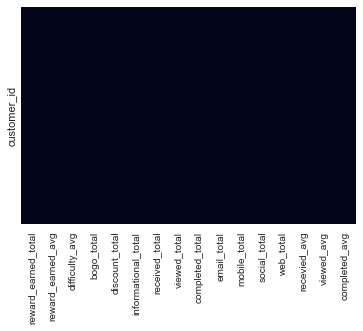

In [94]:
# drop 'became_member_on' col
customer_promo.drop(['became_member_on'], axis=1, inplace=True)
sns.heatmap(promo_interaction.isnull(),yticklabels=False,cbar=False)

In [95]:
customer_promo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14808 entries, 0 to 14807
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          14808 non-null  object 
 1   gender               14808 non-null  object 
 2   age                  14808 non-null  float64
 3   income               14808 non-null  float64
 4   F                    14808 non-null  float64
 5   M                    14808 non-null  float64
 6   O                    14808 non-null  float64
 7   recency              14808 non-null  float64
 8   frequency            14808 non-null  float64
 9   monetary value       14808 non-null  float64
 10  informational_vr     14808 non-null  float64
 11  informational_cr     14808 non-null  float64
 12  discount_vr          14808 non-null  float64
 13  discount_cr          14808 non-null  float64
 14  bogo_vr              14808 non-null  float64
 15  bogo_cr              14808 non-null 

**__ Insights __** 

The final customer_promo dataframe indeed contains 14808 unique customers. <br>

# D. EDA

In [96]:
customer_promo.head()

customer_id gender   age   income    F    M    O  \
0  02c083884c7d45b39cc68e1314fec56c      F  20.0  30000.0  1.0  0.0  0.0   
1  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f      M  42.0  96000.0  0.0  1.0  0.0   
2  54890f68699049c2a04d415abc25e717      M  36.0  56000.0  0.0  1.0  0.0   
3  b2f1cd155b864803ad8334cdf13c4bd2      F  55.0  94000.0  1.0  0.0  0.0   
4  fe97aa22dd3e48c8b143116a8403dd52      F  39.0  67000.0  1.0  0.0  0.0   

   recency  frequency  monetary value  ...  received_total  viewed_total  \
0     18.0       10.0           29.89  ...             2.0           1.0   
1     23.0       12.0          320.48  ...             4.0           4.0   
2     29.0        7.0          118.85  ...             2.0           2.0   
3     24.0        8.0          195.35  ...             3.0           3.0   
4     30.0       11.0          562.77  ...             4.0           4.0   

   completed_total  email_total  mobile_total  social_total  web_total  \
0              0.0          2.0           1.0           1.0        1.0   
1              4.0          4.0           3.0           2.0        4.0   
2              1.0          2.0           2.0           2.0        1.0   
3              1.0          3.0           3.0           2.0        2.0   
4              0.0          2.0           2.0           1.0        1.0   

   recevied_avg  viewed_avg  completed_avg  
0           1.0         0.5       0.000000  
1           1.0         1.0       1.000000  
2           1.0         1.0       0.500000  
3           1.0         1.0       0.333333  
4           2.0         2.0       0.000000  

[5 rows x 33 columns]

### D1.a. Spending habits

In [97]:
# Use `transactions` df because the 'gender' contains only F,M,O (but not 0 generated from fillna)
demographic = transactions[['age','gender','income']]

In [98]:
transactions['gender'].value_counts()

M    8293
F    5979
O     203
Name: gender, dtype: int64

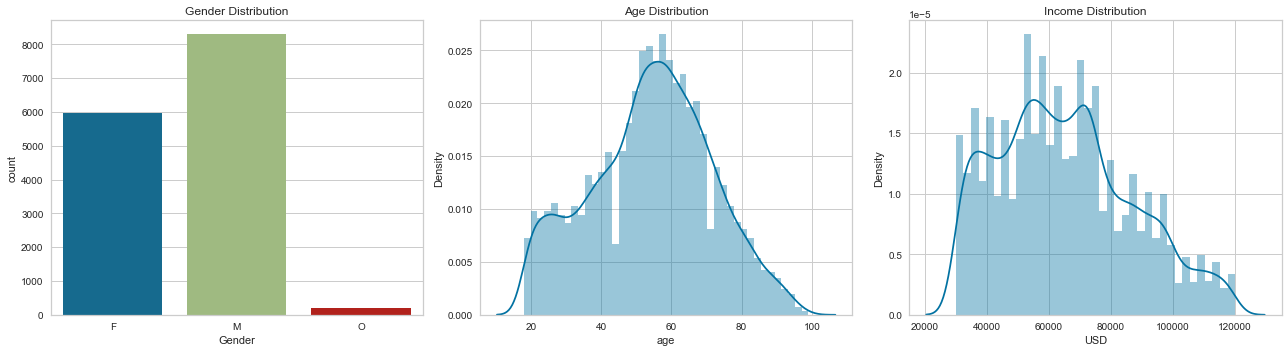

In [99]:
plt.figure(figsize=(18,5))

# gender
plt.subplot(131)
sns.countplot(x=demographic['gender'], data=demographic).set(title='Gender Distribution')
plt.xlabel('Gender');

# age
plt.subplot(132)
sns.distplot(demographic['age']).set(title='Age Distribution')
plt.xlabel('age');

# income
plt.subplot(133)
sns.distplot(demographic['income']).set(title='Income Distribution')
plt.xlabel('USD');

plt.tight_layout()

Transactions made with respect to Gender


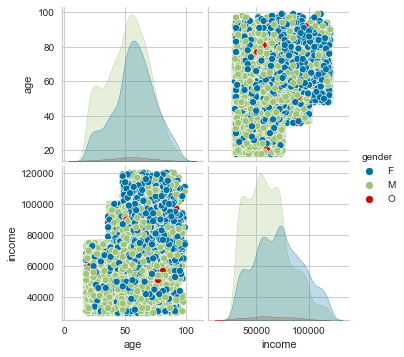

In [100]:
print('Transactions made with respect to Gender')
sns.pairplot(demographic,hue='gender')

In [101]:
demographic.describe()

age         income
count  14475.000000   14475.000000
mean      54.252090   65206.977547
std       17.373633   21595.851767
min       18.000000   30000.000000
25%       42.000000   49000.000000
50%       55.000000   63000.000000
75%       66.000000   79000.000000
max       99.000000  120000.000000

### D1.b. Findings

In [102]:
print('Average age of customers is: {} years old'.format(round(demographic['age'].mean(),0)))
print('Average income of customers is: ${}'.format(round(demographic['income'].mean(),2)))
print('Average transaction is made at: ${}'.format(round(transactions['monetary value'].mean(),2)))

Average age of customers is: 54.0 years old
Average income of customers is: $65206.98
Average transaction is made at: $119.66


- Most customers identified as male
- For transactions more than 300 UDS or so, there is an observed linear between income and the amount spent. This behavior is the same for both genders F and M
- Other gender spends less than F and M

### C3.a. EDA

In [103]:
offers.head()

customer_id            event   day  \
0  78afa995795e4d85b5d9ceeca43f5fef   offer received   0.5   
1  78afa995795e4d85b5d9ceeca43f5fef     offer viewed   1.5   
2  78afa995795e4d85b5d9ceeca43f5fef  offer completed   6.5   
3  e2127556f4f64592b11af22de27a7932   offer received  17.5   
4  e2127556f4f64592b11af22de27a7932     offer viewed  18.5   

                           offer_id gender  age became_member_on    income  F  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75       2017-05-09  100000.0  1   
1  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75       2017-05-09  100000.0  1   
2  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75       2017-05-09  100000.0  1   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9      M   68       2018-04-26   70000.0  0   
4  9b98b8c7a33c4b65b9aebfe6a799e6d9      M   68       2018-04-26   70000.0  0   

   M  ...  channel_web  bogo  discount  informational offer completed  \
0  0  ...            1     1         0              0               0   
1  0  ...            1     1         0              0               0   
2  0  ...            1     1         0              0               1   
3  1  ...            1     1         0              0               0   
4  1  ...            1     1         0              0               0   

   offer received  offer viewed  received_time  viewed_time  completed_time  
0               1             0            0.5          0.0             0.0  
1               0             1            0.0          1.5             0.0  
2               0             0            0.0          0.0             6.5  
3               1             0           17.5          0.0             0.0  
4               0             1            0.0         18.5             0.0  

[5 rows x 28 columns]

In [108]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])

# create labels
labels_type = offers['offer_type'].value_counts().index
labels_event = offers['event'].value_counts().index

# create figures
# Offer types 
fig.add_trace(go.Pie(
     values= offers['offer_type'].value_counts(),
     labels= labels_type,
     name="Offer Types"), 
     row=1, col=1)

# customers response overall 
fig.add_trace(go.Pie(
     values= offers['event'].value_counts(),
     labels= labels_event,
     name="Event"),
    row=1, col=2)
fig.update_layout(title_text='Distribution of Offer Types (L) and Customers Overall Response to Offers (R)')

fig.show()

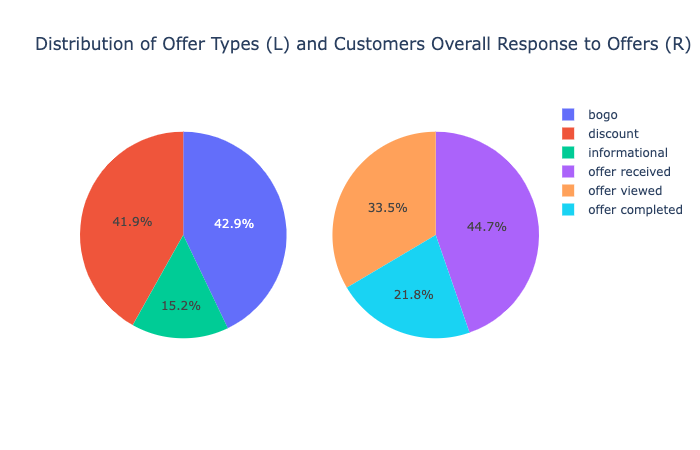

In [104]:
offer_dist = offers[['offer_type', 'event', 'gender']]

In [105]:
offer_dist.head()

offer_type            event gender
0       bogo   offer received      F
1       bogo     offer viewed      F
2       bogo  offer completed      F
3       bogo   offer received      M
4       bogo     offer viewed      M

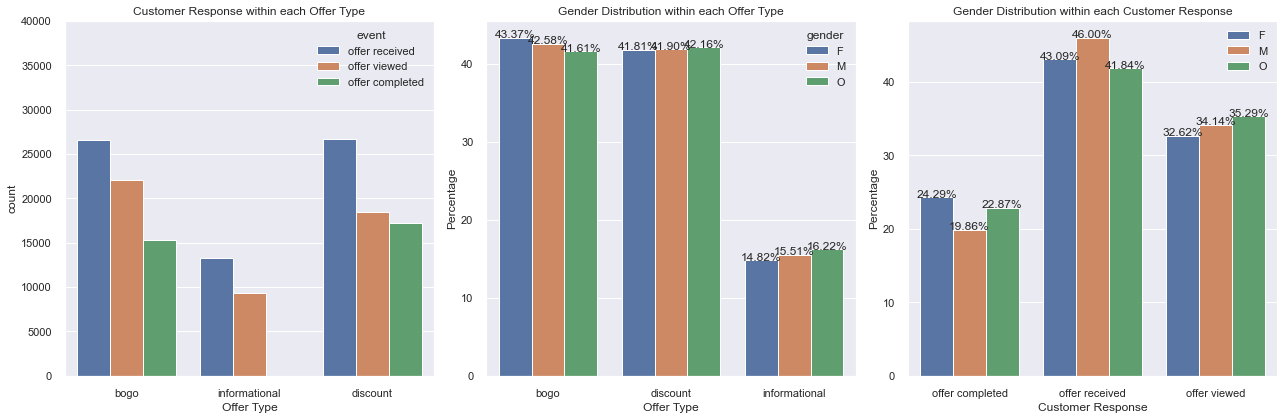

In [106]:
# Create a countplot 
sns.set(style="darkgrid")
plt.figure(figsize=(18, 6))

# Offer type vs customer_response
plt.subplot(131)
sns.countplot(x=offers['offer_type'], hue=offers['event'])
plt.ylim(0,40000)
plt.xlabel('Offer Type')
plt.title('Customer Response within each Offer Type');

# Offer type vs gender
plt.subplot(132)
offer_gender = offer_dist.groupby(['offer_type', 'gender']).size().reset_index(name='Count')
offer_gender['Percentage'] = offer_gender.groupby('gender')['Count'].apply(lambda x: (x / x.sum()) * 100)

# Create the countplot
ax = sns.barplot(x='offer_type', y='Percentage', hue='gender', data=offer_gender)

# Annotate the percentages on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}%', (p.get_x() + p.get_width() / 2., height), ha='center')
plt.xlabel('Offer Type')
plt.title('Gender Distribution within each Offer Type');
    

plt.subplot(133)
res_gender = offer_dist.groupby(['event', 'gender']).size().reset_index(name='Count')
res_gender['Percentage'] = res_gender.groupby('gender')['Count'].apply(lambda x: (x / x.sum()) * 100)

# Create the countplot
ax = sns.barplot(x='event', y='Percentage', hue='gender', data=res_gender)

# Annotate the percentages on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}%', (p.get_x() + p.get_width() / 2., height), ha='center')
plt.xlabel('Customer Response')
plt.title('Gender Distribution within each Customer Response');

# Show the plot
plt.ylabel('Percentage')
plt.legend(loc='best')
# plt.show()

plt.tight_layout()

### C3.b. Insights

- Dominant offers are BOGO (42.9%) and Discount (41.9%)
- Female completed offers most 

**Rate**
- Purchase usually comes from Discount then BOGO
- View rate = 33.5%
- Purchase rate (conversion rate) = 21.8%

### C3.c. Brief Assessments based on Pearson Correlation

In [107]:
offers_simp.head()

customer_id                          offer_id   day  \
1  0009655768c64bdeb2e877511632db8f  3f207df678b143eea3cee63160fa8bed  16.5   
2  0009655768c64bdeb2e877511632db8f  5a8bc65990b245e5a138643cd4eb9837   8.5   
5  0011e0d4e6b944f998e987f904e8c1e5  0b1e1539f2cc45b7b9fa7c272da2e1d7  24.5   
6  0011e0d4e6b944f998e987f904e8c1e5  2298d6c36e964ae4a3e7e9706d1fb8c2  11.5   
7  0011e0d4e6b944f998e987f904e8c1e5  3f207df678b143eea3cee63160fa8bed   1.5   

  gender  age became_member_on   income  F  M  O  ...  informational  \
1      M   33       2017-04-21  72000.0  0  1  0  ...              1   
2      M   33       2017-04-21  72000.0  0  1  0  ...              1   
5      O   40       2018-01-09  57000.0  0  0  1  ...              0   
6      O   40       2018-01-09  57000.0  0  0  1  ...              0   
7      O   40       2018-01-09  57000.0  0  0  1  ...              1   

   offer completed  offer received offer viewed  received_time  viewed_time  \
1                0               1            1           14.5         16.5   
2                0               1            1            7.5          8.5   
5                1               1            1           17.5         18.5   
6                1               1            1            7.5          8.5   
7                0               1            1            0.5          1.5   

   completed_time  due_time  viewed_valid  completed_valid  
1             0.0      18.5             1                0  
2             0.0      10.5             1                0  
5            24.5      27.5             1                1  
6            11.5      14.5             1                1  
7             0.0       4.5             1                0  

[5 rows x 30 columns]

In [108]:
data = [go.Heatmap(
        z= offers_simp.corr().values,
        x= offers_simp.columns.values,
        y= offers_simp.columns.values,
        colorscale='RdBu_r',
        opacity = 1.0 )]

layout = go.Layout(
    title='Pearson Correlation of Input Features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks=''),
    width = 900, height = 700)

fig = go.Figure(data=data, layout=layout)
fig.show()

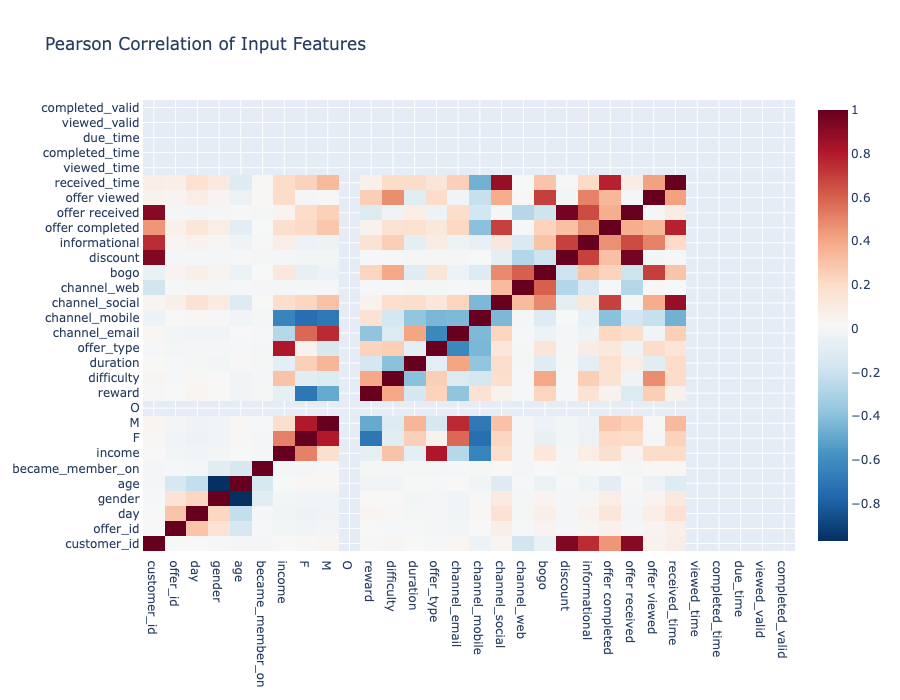

In [109]:
# Features that correlate with Conversion 
offers_simp.corr()['offer completed'].sort_values(ascending=False)

offer completed    1.000000
completed_valid    0.876167
completed_time     0.694738
offer viewed       0.485694
viewed_valid       0.379985
offer received     0.328165
duration           0.307778
discount           0.235055
difficulty         0.230955
reward             0.196409
channel_web        0.189174
channel_social     0.186741
income             0.160519
bogo               0.137831
viewed_time        0.127077
F                  0.107345
age                0.073134
channel_mobile     0.059845
day                0.033759
O                  0.017714
due_time          -0.001580
received_time     -0.083701
M                 -0.111043
informational     -0.430242
channel_email           NaN
Name: offer completed, dtype: float64

**__ Insights __**

Features that influence the customers response to make purchase using offers are: 
- duration of the offers
- discount offer
- difficult level 
- reward amount 
- offers advertised on website and social platforms 
- customer income
- BOGO offer
- female, despite earlier observation that males receive more offers and more responsive (i.e. view the offers)
- age

# D. Modeling

Purpose: Confirm the effectivness of the current user-targeting and promo-offering stratagies used by starbucks

Method: build a predictive model to measure conversion accuracy. Use established metrics as baseline for future A/B testing

## Thought Process

1. Develop a **customer segmentation** model:
    - K-means clustering with elbow an silhouette methods
    - OPTICS method


2. A model to **predict** which customer should receive offers to yield high coversion rate
    - are we giving out the promotional offers to the right audiences that increasing the profit?
    - the 'complete_valid' column indiciates a true converted customer

## D1. Customer Segmentation

In [110]:
customer_promo.head()

customer_id gender   age   income    F    M    O  \
0  02c083884c7d45b39cc68e1314fec56c      F  20.0  30000.0  1.0  0.0  0.0   
1  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f      M  42.0  96000.0  0.0  1.0  0.0   
2  54890f68699049c2a04d415abc25e717      M  36.0  56000.0  0.0  1.0  0.0   
3  b2f1cd155b864803ad8334cdf13c4bd2      F  55.0  94000.0  1.0  0.0  0.0   
4  fe97aa22dd3e48c8b143116a8403dd52      F  39.0  67000.0  1.0  0.0  0.0   

   recency  frequency  monetary value  ...  received_total  viewed_total  \
0     18.0       10.0           29.89  ...             2.0           1.0   
1     23.0       12.0          320.48  ...             4.0           4.0   
2     29.0        7.0          118.85  ...             2.0           2.0   
3     24.0        8.0          195.35  ...             3.0           3.0   
4     30.0       11.0          562.77  ...             4.0           4.0   

   completed_total  email_total  mobile_total  social_total  web_total  \
0              0.0          2.0           1.0           1.0        1.0   
1              4.0          4.0           3.0           2.0        4.0   
2              1.0          2.0           2.0           2.0        1.0   
3              1.0          3.0           3.0           2.0        2.0   
4              0.0          2.0           2.0           1.0        1.0   

   recevied_avg  viewed_avg  completed_avg  
0           1.0         0.5       0.000000  
1           1.0         1.0       1.000000  
2           1.0         1.0       0.500000  
3           1.0         1.0       0.333333  
4           2.0         2.0       0.000000  

[5 rows x 33 columns]

In [111]:
# make the 'customer_id' column as index and drop the 'gender' cols 
# because the scaler can't apply on str
customer_promo.drop(['gender'],axis=1,inplace=True)
customer_promo.set_index('customer_id',inplace=True)

### D1.a. Feature Scaling

In [112]:
scaler = StandardScaler().fit(customer_promo)
customer_promo_scaled = scaler.transform(customer_promo)

### D1.b. Dimensionality Reduction using PCA

In [113]:
# instantiate a PCA object
pca = PCA()
# fit the PCA on the scaled dataset and transform it
X_pca = pca.fit_transform(customer_promo_scaled)

In [114]:
# individual explained variance 
var_exp = pca.explained_variance_ratio_

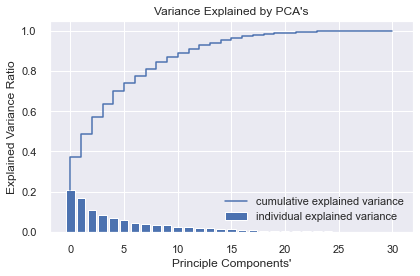

In [115]:
# Plot the explained variance ratios
x = np.arange(len(var_exp))
plt.bar(x, var_exp, label='individual explained variance')
plt.step(x, np.cumsum(var_exp), label='cumulative explained variance')

plt.xlabel("Principle Components")
plt.ylabel("Explained Variance Ratio")
plt.legend(loc='best')
plt.title("Variance Explained by PCA's")

plt.tight_layout()

**__ Insights __**
- The first 5 components explained about 75% of the variance
- The first 10 components explained about 90% of the variance 
- Starting the 6th to the 10th, I don't observe much variance change. I'm going to choose 80% (about average) variance as the top limit to find the optimal principal components

In [116]:
# cumulative explained variances
cum_var_exp = np.cumsum(var_exp)
# number of components is the size of the matrix where the cumulative sum is <= 80%
n_components = len(cum_var_exp[cum_var_exp <= 0.8])

# reduce the dimensionality with the generated numbers of principle components 
pca = PCA(n_components=n_components).fit(customer_promo_scaled)
# transform the dataset
X_pca = pca.fit_transform(customer_promo_scaled) 

### D1.c. Find the optimal number of clusters

### Using K-means

In [117]:
from yellowbrick.cluster import KElbowVisualizer

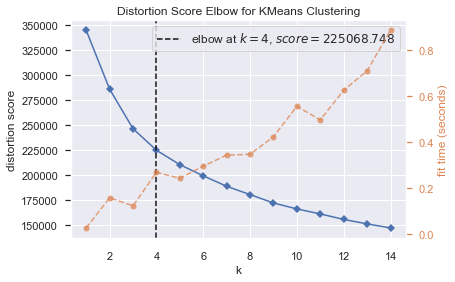

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=14), k=(1, 15))

In [118]:
# elbow method
kelbow_visualizer(KMeans(), X_pca, k=(1,15))

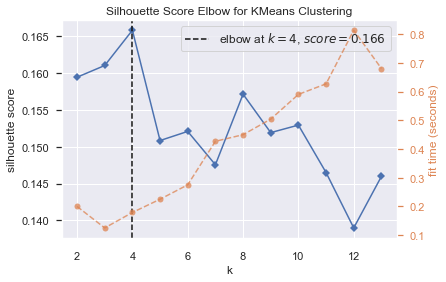

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>,
                 estimator=KMeans(n_clusters=13), k=(2, 14),
                 metric='silhouette')

In [119]:
# silhouette method
kelbow_visualizer(KMeans(), X_pca, k=(2,14), metric='silhouette')

**__ Foundings __**

Both elbow and silhouette methods result in **cluster = 4**

In [120]:
# instansiate a k-means model with 4 clusters
model = KMeans(n_clusters=4, random_state=28).fit(X_pca)
# predict the cluster each data point belong to
kmeans_clusters = model.predict(X_pca)

In [121]:
kmeans_clusters

array([2, 3, 0, ..., 1, 1, 1], dtype=int32)

### Using OPTICS

In [122]:
# define the model
model = OPTICS(eps = 0.8, min_samples=35)
# fit model and predict clusters
optics_clusters = model.fit_predict(X_pca)
# retrieve unique clusters
clusters = np.unique(optics_clusters)

In [123]:
print('Number of clusters analyzed by OPTICS:', len(clusters))

Number of clusters analyzed by OPTICS: 4


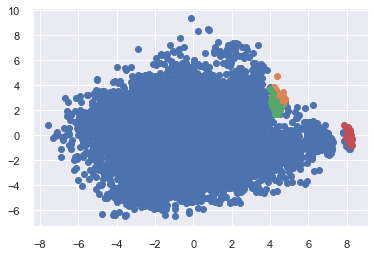

In [124]:
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(optics_clusters == cluster)
    # create scatter of these samples
    plt.scatter(X_pca[row_ix, 0], X_pca[row_ix, 1])
# show the plot
plt.show()

<AxesSubplot:ylabel='Count'>

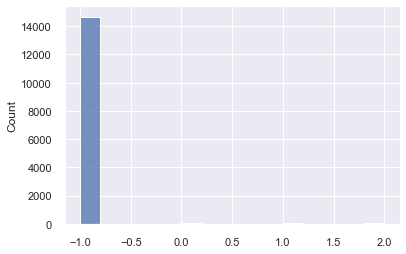

In [125]:
sns.histplot(optics_clusters)

**__ Foundings __**

OPTICS method produces **4 clusters**, but there is a lot of noise (-1)

### D1.d. Evaluate the segmentation

### K-means

In [126]:
cp_kmeans = customer_promo.copy().reset_index()

# create 'cluster' col containing predicted values (aka clusters 1-4) 
cp_kmeans['cluster'] = kmeans_clusters
# drop the 'informational_cr' col since they're all 0s
cp_kmeans.drop(['informational_cr'], axis=1, inplace=True)

cp_kmeans.head()

customer_id   age   income    F    M    O  recency  \
0  02c083884c7d45b39cc68e1314fec56c  20.0  30000.0  1.0  0.0  0.0     18.0   
1  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f  42.0  96000.0  0.0  1.0  0.0     23.0   
2  54890f68699049c2a04d415abc25e717  36.0  56000.0  0.0  1.0  0.0     29.0   
3  b2f1cd155b864803ad8334cdf13c4bd2  55.0  94000.0  1.0  0.0  0.0     24.0   
4  fe97aa22dd3e48c8b143116a8403dd52  39.0  67000.0  1.0  0.0  0.0     30.0   

   frequency  monetary value  informational_vr  ...  viewed_total  \
0       10.0           29.89               0.0  ...           1.0   
1       12.0          320.48               0.0  ...           4.0   
2        7.0          118.85               1.0  ...           2.0   
3        8.0          195.35               1.0  ...           3.0   
4       11.0          562.77               1.0  ...           4.0   

   completed_total  email_total  mobile_total  social_total  web_total  \
0              0.0          2.0           1.0           1.0        1.0   
1              4.0          4.0           3.0           2.0        4.0   
2              1.0          2.0           2.0           2.0        1.0   
3              1.0          3.0           3.0           2.0        2.0   
4              0.0          2.0           2.0           1.0        1.0   

   recevied_avg  viewed_avg  completed_avg  cluster  
0           1.0         0.5       0.000000        2  
1           1.0         1.0       1.000000        3  
2           1.0         1.0       0.500000        0  
3           1.0         1.0       0.333333        0  
4           2.0         2.0       0.000000        0  

[5 rows x 32 columns]

In [127]:
cp_kmeans = cp_kmeans.melt(id_vars=['customer_id','cluster'])
cp_kmeans.head()

customer_id  cluster variable  value
0  02c083884c7d45b39cc68e1314fec56c        2      age   20.0
1  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f        3      age   42.0
2  54890f68699049c2a04d415abc25e717        0      age   36.0
3  b2f1cd155b864803ad8334cdf13c4bd2        0      age   55.0
4  fe97aa22dd3e48c8b143116a8403dd52        0      age   39.0

In [128]:
# What are the clusters
cp_kmeans['cluster'].value_counts()

3    145260
1    125130
2     91620
0     82230
Name: cluster, dtype: int64

In [129]:
cp_kmeans = cp_kmeans.groupby(['cluster','variable']).mean().reset_index()
cp_kmeans

cluster      variable      value
0          0             F   0.456403
1          0             M   0.523167
2          0             O   0.011310
3          0           age  55.120029
4          0       bogo_cr   0.003101
..       ...           ...        ...
115        3  social_total   2.585915
116        3      total_cr   0.889515
117        3    viewed_avg   1.102657
118        3  viewed_total   4.151384
119        3     web_total   3.048947

[120 rows x 3 columns]

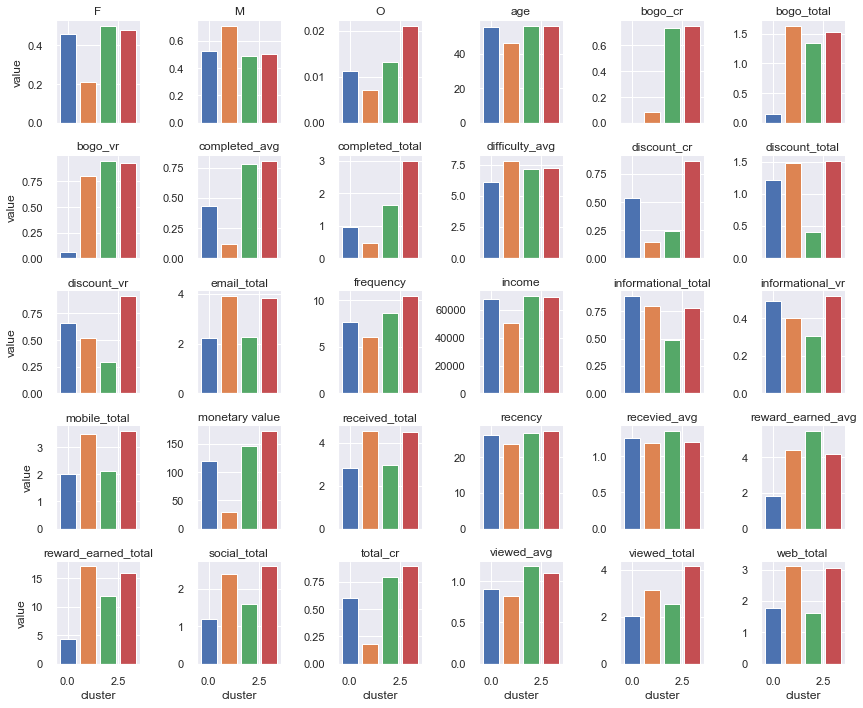

In [130]:
# Graph the groupby dataset above
g_kmeans = sns.FacetGrid(cp_kmeans, col='variable', hue='cluster', col_wrap=6, height=2, sharey=False)
g_kmeans = g_kmeans.map(plt.bar, 'cluster', 'value').set_titles("{col_name}")

### D1.e. Segmentation Conclusions

I'm going to analazye the clusters based on Kmeans method because it produces more distinguished and pronounced clusters than OPTICS. Recall the graphs for followed analysis.

There are four clusters coded in colors: blue, green, red, and purple.

### Segment 1 (blue)

Customers in this segment receive **rarely to no BOGO offers**. They recevie *mainly discount offers* and informational ones. Given discount offers received, the customers convey an average convert rate.

This group makes frequent and regular purchases (frequency, monetary value). Thus, either they *can continue to receive some promotional offers or not*. It's likely that they will make purchases at Starbucks regardless.

### Segment 2 (orange)

Customers in this segment exhibits a **very low conversion rate but receive offers regularly**. This group receives all 3 promotional offers via all channels. Although their **view rates score slighly high on average**, the completed rates and **total conversion rates are very low**. 

Most customers in this group idetify as **Male and has a lower income on average** compared to the other groups. It is recommended to **stop sending offers** to this group for future campaign. 

### Segment 3 (green)

Customers in this segment receive **mainly BOGO offers and they convert very well**. This group receive BOGO offers regularly and higher than average, but lower in discount offers. Their completed rate on BOGO offers and total conversion rate are high (total_cr). Although the data showed that the level of marketing reachout is only average (mobile, web, and social), this group is very interactive to the received offers. 

The demographic of this group consits of **female and male identified** with average age and income similarly to the other three groups. It's recommended to **target this group** with *more BOGO* offers  


### Segment 4 (red)

Customers in this segment **oftenly receive offers and they convert very well**. They receive all promotinal offer types (BOGO, discount, and informational) via all channels. 

It's observed that this group on average viewed and completed that offers higher than other groups (viewed_total, completed_total), which results in **very high conversion rates** for both discount and BOGO (discount_cr, bogo_cr, total_cr). It seems like customers in this group are *more receptive to discount* than bogo and they also frequently make purchases (frequency). 

The attributes of this group are **genders identified as Female and Male** with similar age and income compared to the average of the other segments. This group should continue to **be the target** of the promotional stategy.  

In [132]:
# copy the original dataset because the cp_kmeans is a groupby table
c_segments = customer_promo.copy().reset_index()
c_segments['cluster'] = kmeans_clusters
c_segments = c_segments.melt(id_vars=['customer_id','cluster'])

[Text(0.5, 1.0, 'Customers Count in each Clusters')]

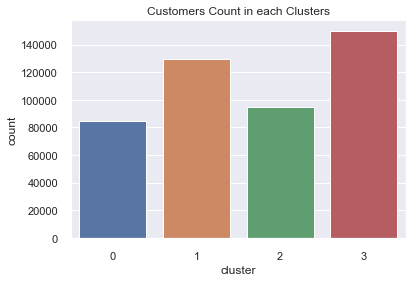

In [135]:
sns.countplot(x=c_segments['cluster']).set(title='Customers Count in each Clusters')

# E. Build a Predictive Model¶
**Within the treated group receiving promotional offers, the labels are purchase (1), don't purchase (0)**

I'm going to use the following classification models:
- Logistic Regression
- KNN
- Random Forest

## Evaluate the important metrics

Since it costs money to send out the promotional offers, I want to focus on **accuracy and precision**. 

Based on the current clusters (see graph above), it looks like there are a significant amount of customers that receive offers but never convert. Thus, I want to stop sending out offers to this pool, which means **minimize** the wrongly predicted converted-customers (**FP**) 

[Text(0.5, 1.0, 'Total Conversion Rate Distribution')]

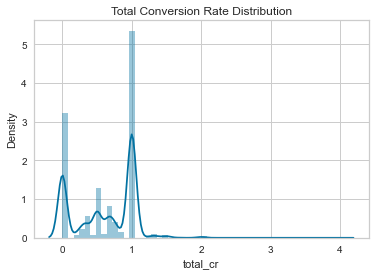

In [141]:
sns.distplot(customer_promo['total_cr']).set(title='Total Conversion Rate Distribution')

[Text(0.5, 1.0, 'Conversion Labels')]

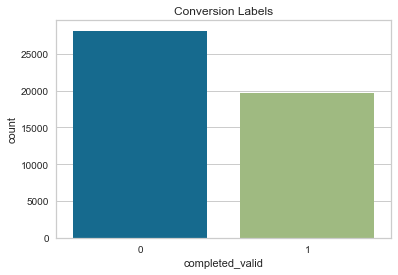

In [142]:
sns.countplot(offers_simp['completed_valid']).set(title='Conversion Labels')

In [143]:
offers_simp.head()

customer_id                          offer_id   day  \
1  0009655768c64bdeb2e877511632db8f  3f207df678b143eea3cee63160fa8bed  16.5   
2  0009655768c64bdeb2e877511632db8f  5a8bc65990b245e5a138643cd4eb9837   8.5   
5  0011e0d4e6b944f998e987f904e8c1e5  0b1e1539f2cc45b7b9fa7c272da2e1d7  24.5   
6  0011e0d4e6b944f998e987f904e8c1e5  2298d6c36e964ae4a3e7e9706d1fb8c2  11.5   
7  0011e0d4e6b944f998e987f904e8c1e5  3f207df678b143eea3cee63160fa8bed   1.5   

  gender  age became_member_on   income  F  M  O  ...  informational  \
1      M   33       2017-04-21  72000.0  0  1  0  ...              1   
2      M   33       2017-04-21  72000.0  0  1  0  ...              1   
5      O   40       2018-01-09  57000.0  0  0  1  ...              0   
6      O   40       2018-01-09  57000.0  0  0  1  ...              0   
7      O   40       2018-01-09  57000.0  0  0  1  ...              1   

   offer completed  offer received offer viewed  received_time  viewed_time  \
1                0               1            1           14.5         16.5   
2                0               1            1            7.5          8.5   
5                1               1            1           17.5         18.5   
6                1               1            1            7.5          8.5   
7                0               1            1            0.5          1.5   

   completed_time  due_time  viewed_valid  completed_valid  
1             0.0      18.5             1                0  
2             0.0      10.5             1                0  
5            24.5      27.5             1                1  
6            11.5      14.5             1                1  
7             0.0       4.5             1                0  

[5 rows x 30 columns]

### Thought process
- use offers_simp df for creating predictive model
- remove informational offers because they don't convert customers
- remove unnecessary columns

In [160]:
offers_simp.columns

Index(['customer_id', 'offer_id', 'day', 'gender', 'age', 'became_member_on',
       'income', 'F', 'M', 'O', 'reward', 'difficulty', 'duration',
       'offer_type', 'channel_email', 'channel_mobile', 'channel_social',
       'channel_web', 'bogo', 'discount', 'informational', 'offer completed',
       'offer received', 'offer viewed', 'received_time', 'viewed_time',
       'completed_time', 'due_time', 'viewed_valid', 'completed_valid'],
      dtype='object')

In [161]:
promo = offers_simp.copy()

# Remove unnecessary information
promo.drop(['customer_id', 'offer_id', 'day', 'gender', 'age', 'became_member_on', 'offer_type', 
            'offer completed','offer received', 'offer viewed', 'received_time', 'viewed_time', 'completed_time', 
            'due_time', 'viewed_valid', 'channel_email'], axis=1, inplace=True)
promo.head()

income  F  M  O  reward  difficulty  duration  channel_mobile  \
1  72000.0  0  1  0       0           0         4               1   
2  72000.0  0  1  0       0           0         3               1   
5  57000.0  0  0  1       5          20        10               0   
6  57000.0  0  0  1       3           7         7               1   
7  57000.0  0  0  1       0           0         4               1   

   channel_social  channel_web  bogo  discount  informational  completed_valid  
1               0            1     0         0              1                0  
2               1            0     0         0              1                0  
5               0            1     0         1              0                1  
6               1            1     0         1              0                1  
7               0            1     0         0              1                0

In [162]:
promo.corr()['completed_valid'].sort_values(ascending=False)

completed_valid    1.000000
duration           0.331297
discount           0.255206
difficulty         0.246160
reward             0.204958
channel_social     0.204233
channel_web        0.203413
income             0.169726
bogo               0.141311
F                  0.113899
channel_mobile     0.063957
O                  0.021396
M                 -0.118454
informational     -0.457464
Name: completed_valid, dtype: float64

<AxesSubplot:>

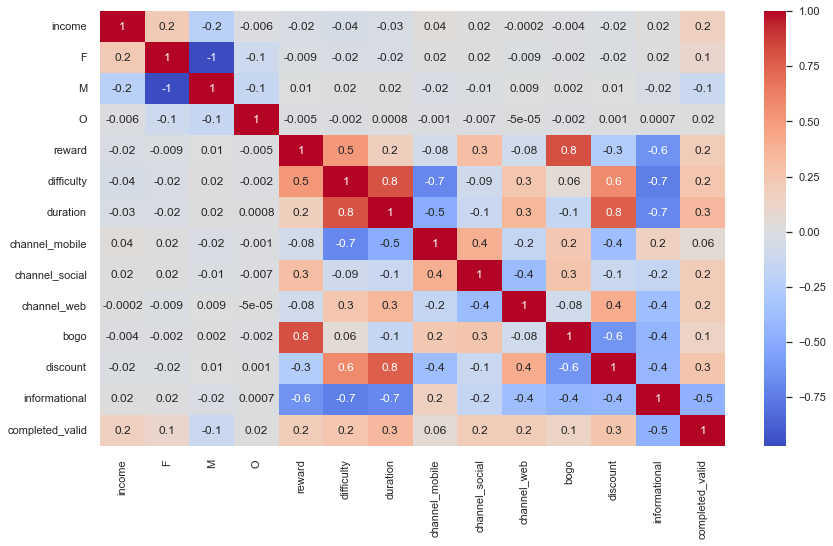

In [163]:
plt.figure(figsize=(14,8))
sns.heatmap(promo.corr(),annot=True, cmap='coolwarm',fmt='.1g')

**__ Insights __**

Compared to the previous Pearson correlation analysis, factors that positively correlated with customer converted stay the same. The top factors are the **offers' attributes**: promotions' duration, difficulty, amount reward, and advertisement platform. Customers are more likely to utilize **discounts** than BOGO. 

## E1. Train - Test Split

In [164]:
X = promo.drop('completed_valid',axis=1)
y = promo['completed_valid']

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [175]:
# Upsampling with SMOTE
oversample = SMOTE()
X_train_ups, y_train_ups = SMOTE(sampling_strategy='minority', random_state=42).fit_resample(X_train, y_train)

## E2. Hyper-Parameters Tuning: KNN

In [166]:
k_range = range(1,41)
param_grid_knn = dict(n_neighbors=k_range)

for k in k_range:
    grid_knn = GridSearchCV(KNeighborsClassifier(n_neighbors=k), param_grid_knn, cv=10,scoring='accuracy')

In [176]:
grid_knn.fit(X_train_ups,y_train_ups)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(n_neighbors=40),
             param_grid={'n_neighbors': range(1, 41)}, scoring='accuracy')

In [177]:
grid_knn.best_params_

{'n_neighbors': 31}

## E3. Create the models

In [178]:
# instantiate and fit the models on the training set
log = LogisticRegression().fit(X_train_ups, y_train_ups)
knn = KNeighborsClassifier(n_neighbors=31).fit(X_train_ups, y_train_ups)
brfc = BalancedRandomForestClassifier().fit(X_train_ups, y_train_ups)
xgb = XGBClassifier(learning_rate=0.1, objective = 'binary:logistic').fit(X_train_ups,y_train_ups)

In [179]:
models = [log, knn, brfc, xgb]
models_names = ['Logistic Regression', 'KNN', 'Balance Random Forest', 'XGBoost']

## E4. Applying k-fold cross validation on the Train set

In [180]:
scoring = ['accuracy','precision','recall']
train_accuracy = []
train_precision = []
train_recall = []
train_std = []

train_scoring = {}
for i,model in enumerate (models):
    scores = cross_validate(model, X_train_ups, y_train_ups, cv=10, scoring=scoring)
    train_accuracy.append(scores['test_accuracy'].mean())
    train_precision.append(scores['test_precision'].mean())
    train_recall.append(scores['test_recall'].mean())
    train_std.append(scores['test_accuracy'].std())
    
    train_scoring[i] = scores['test_accuracy'] # for graphing purpose below

In [181]:
train_scores = pd.DataFrame(list(zip(train_accuracy,train_precision,train_recall,train_std)),
                            index=models_names,columns=['Accuracy','Precision','Recall','Standard Deviation'])
print('Models Training Scores')
train_scores

Models Training Scores


Accuracy  Precision    Recall  Standard Deviation
Logistic Regression    0.552906   0.538835  0.925692            0.065103
KNN                    0.748177   0.731663  0.783863            0.008646
Balance Random Forest  0.751850   0.717424  0.830769            0.014011
XGBoost                0.760435   0.723812  0.842216            0.010024

### Compare the models

Text(0, 0.5, 'Accuracy rate')

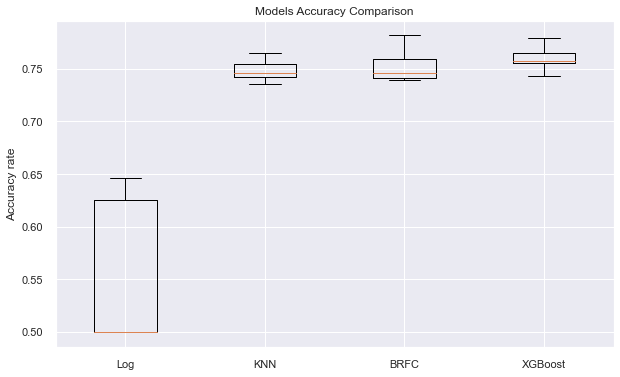

In [183]:
fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(train_scoring.values())
ax.set_xticklabels(['Log','KNN','BRFC','XGBoost'])

plt.title('Models Accuracy Comparison')
plt.ylabel('Accuracy rate')

**__ Insights __**

XGBoost model achieves the high scores in all the metrics, followed by balanced RFC

Side notes: 

Without using SMOTE: Logistic Regression model produces 0.0 scores on precision and recall. This inidicates that this model can't predict 1's label due to imbalanced data. It could have been trained with dominant 0's label. 

**Choose XGBoost** as the classifier

## E5. Test the model

In [226]:
# Apply the model on X_test
y_pred = xgb.predict(X_test)

# Probability of predicted y_test
y_pred_prob = xgb.predict_proba(X_test)[:,1]

# Create a df for Test Set output
test_output = pd.DataFrame({'True Converted':y_test.values, 
                            'Predict Probability':y_pred_prob, 
                           'Predict Converted':y_pred})

# Lead Score
test_output['Lead Score'] = round(test_output['Predict Probability']*100)

test_output.head()

True Converted  Predict Probability  Predict Converted  Lead Score
0               1             0.494339                  0        49.0
1               0             0.000129                  0         0.0
2               1             0.734003                  1        73.0
3               0             0.253094                  0        25.0
4               1             0.622196                  1        62.0

In [196]:
# Classification report
print(classification_report(y_test,y_pred))

# Confusion matrix
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.69      0.76      8418
           1       0.65      0.82      0.73      5929

    accuracy                           0.75     14347
   macro avg       0.75      0.76      0.74     14347
weighted avg       0.77      0.75      0.75     14347

[[5815 2603]
 [1043 4886]]


In [223]:
conf_matrix = confusion_matrix(y_test,y_pred)
tn = conf_matrix[0,0]
fp = conf_matrix[0,1]
tp = conf_matrix[1,1]
fn = conf_matrix[1,0]

total = tn + fp + tp + fn

accuracy  = (tp + tn) / total # Accuracy Rate
precision = tp / (tp + fp) # Positive Predictive Value
recall    = tp / (tp + fn) # True Positive Rate
error = (fp + fn) / total # Missclassification Rate

print(f'Accuracy: {accuracy:.2f}', '\n'
      f'Precision: {precision:.2f}', '\n'
      f'Recall: {recall:.2f}', '\n' 
      f'Error: {error:.2f}')

Accuracy: 0.75 
Precision: 0.65 
Recall: 0.82 
Error: 0.25


## E6. Gain and Lift Charts

In [238]:
def plot_lift_curve(y_val, y_pred, step=0.01):
    
    #Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    #Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_val 
    aux_lift['predicted'] = y_pred #array containing the probability predictions for such data
    #Order the values for the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)
    
    #Create the values that will go into the X axis of our plot
    x_val = np.arange(step,1+step,step)
    #Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    #Create an empty vector with the values that will go on the Y axis our our plot
    y_v = []
    
    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) #The ceil function returns the closest integer bigger than our number 
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)
           
   #Plot the figure
    plt.figure(figsize=(8, 6))
    plt.plot(x_val, y_v, 'g-', linewidth = 3, markersize = 5, label='Lift Curve')
    plt.plot(x_val, np.ones(len(x_val)), 'k-', linestyle='dashed', label='Baseline')
    plt.xlabel('Proportion of sample')
    plt.ylabel('Lift')
    plt.legend()
    plt.title('Lift Curve')
    plt.show()

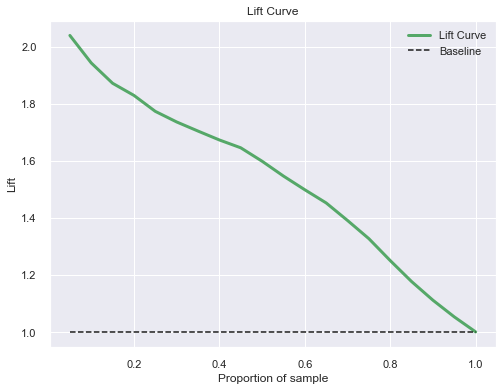

In [239]:
plot_lift_curve(y_test, y_pred_prob, step=0.05)

In [204]:
# Your model predictions (predicted probabilities)
model_predictions = y_test_pred  # Replace with your model's predictions 
actual_outcomes = y_test.values  # Replace with actual outcomes (0 for non-response, 1 for response)

In [207]:
# Calculate Lift Values
def calculate_lift(model_predictions, actual_outcomes, num_percentiles=10):
    # Sort predictions and actual outcomes by predicted probability
    sorted_indices = np.argsort(model_predictions, kind='heapsort')[::-1]
    sorted_predictions = model_predictions[sorted_indices]
    sorted_actual_outcomes = actual_outcomes[sorted_indices]

    # Calculate the number of observations in each percentile
    num_samples = len(model_predictions)
    samples_per_percentile = num_samples // num_percentiles

    # Initialize lists to store cumulative values
    cumulative_percentiles = []
    cumulative_lift_model = []
    cumulative_lift_baseline = []

    # Calculate cumulative response rates and lift values
    for i in range(1, num_percentiles + 1):
        end_index = i * samples_per_percentile
        percentile_predictions = sorted_predictions[:end_index]
        percentile_actual_outcomes = sorted_actual_outcomes[:end_index]
        
        cumulative_percentiles.append(i * 100 / num_percentiles)
        cumulative_lift_model.append(np.sum(percentile_actual_outcomes) / np.sum(sorted_actual_outcomes))

        # Calculate baseline lift (random targeting)
        baseline_percentile_size = i * num_samples // num_percentiles
        baseline_lift = baseline_percentile_size / num_samples
        cumulative_lift_baseline.append(baseline_lift)

    return cumulative_percentiles, cumulative_lift_model, cumulative_lift_baseline

cumulative_percentiles, cumulative_lift_model, cumulative_lift_baseline = calculate_lift(model_predictions, actual_outcomes)


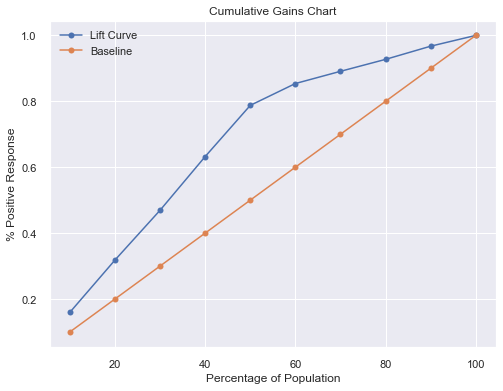

In [210]:
# Plot the Gains Chart
def plot_gains_chart(cumulative_percentiles, cumulative_lift_model, cumulative_lift_baseline):
    plt.figure(figsize=(8, 6))
    plt.plot(cumulative_percentiles, cumulative_lift_model, marker='o', linestyle='-', label='Lift Curve')
    plt.plot(cumulative_percentiles, cumulative_lift_baseline, marker='o', linestyle='-', label='Baseline')
    plt.xlabel('Percentage of Population')
    plt.ylabel('% Positive Response')
    plt.title('Cumulative Gains Chart')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_lift_chart(cumulative_percentiles, cumulative_lift_model, cumulative_lift_baseline)

**__Insights__**

The lift and gains charts show such powerful improvement because the dataset tested on contains all customers *receiving offers*. Therefore a significant portion of receiving offers show big lift compared to the baseline

# E. Conclusion and Discussion

At a high level, purchases made during this promotion period carry some charactersistics:
- Customers are more receptive to discounts and BOGOs
- Male are hihgly interactive with offers (receive, view, and complete). They are also the customers that currently receive more offers compared to other genders (female, other, unspecified)
- Most amount spent is up to 200 USD
- Amount spent is in correlation with customers' incomes. 

## Offer personalization

Based on the segmentation analysis, **4 groups of customers** were identified. Three (3) clusters convert well and make regular purchases.

**Receive offers regularly**: 
- convert very well
- is also currently the target audience to receive many offers compared to other genders in all age group
- male and female identified

**Receive BOGOs**:
- convert very well
- mainly receive BOGOs offers and utilize them
- male and female identified

**Don't receive BOGOs at all, but mainly discounts**
- rarely receive any BOGOs
- make frequent purchases with or without offers

**Receive many offers but don't convert**
- frequently receive offers but never open nor complete
- mainly male

We can continue to send out offers that are **discount and BOGO** since they drive customers' buying decisions. The reward value also excite customers.

The source of offers that highly correlates with conversion rate are **social and website**. Here is the cue that we should focus on optimizing the presentation of offers on Starbucks social platform and homepage.

## How effective are the offers?

Currently, purchase usually comes from Discount then BOGO 
- current converion rate is 21.8%**
- view rate is 33.5%
    
However, the offers are significantly spent on one wrong audience, whom don't interact with the offers. This group is the second large in size of this test. The KNN predictve model produces an accuracy scores of about 73% on both train and validation data sets. This indicates that the model is effective enough to predict the conversion of customers who receive offers.

## Next steps

More sophisticated strategies could be employed to achieve a higher conversion rate among Starbucks customers. Uplift modeling can be used to identify the right customer group for a specific promotion. The uplift model method of "two classifiers" can be used. The process will consist of two steps: 

1. Conduct a randomized A/B test, in which the treatment group of customers receives and offers and the control group does not. Train classifiers to predict the likelihood (probability) of conversion for both groups. Add two classifiers into one using a special library (upliftML , casualML). Use a combined classifier on the entire customer base to identify customers with high conversion probability.
2. Conduct a second A/B test, in which the treatment group is customers with a high conversion probability receive promo offers and the control group consisting of random customers also receive promo offers. Calculate lift as the difference in total conversion or total amount spent. 

This method allows for more quantitative customer segmentation and promo offerings, rather than qualitative, human-decision-based strategies.   



# References

- Udacity Data Science Capstone project
- Starbucks

### Extra: Test the Models

In [184]:
def model_performance_report(models):
    """
    This function computes the confusion matrix and classification for the model. 
    The function summaries performance scores: accuracy, precision, recall, and error rate
    """
    
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    error_rate = []

    for i,model in enumerate (models):
        y_pred = model.predict(X_test)
        conf_matrix = confusion_matrix(y_test,y_pred)

        print('\n')
        print(models_names[i])
        print(classification_report(y_test,y_pred))
        '\n'
        print(conf_matrix)
        
        tn = conf_matrix[0,0]
        fp = conf_matrix[0,1]
        tp = conf_matrix[1,1]
        fn = conf_matrix[1,0]

        total = tn + fp + tp + fn

        accuracy  = (tp + tn) / total # Accuracy Rate
        precision = tp / (tp + fp) # Positive Predictive Value
        recall    = tp / (tp + fn) # True Positive Rate
        error = (fp + fn) / total # Missclassification Rate

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        error_rate.append(error)
    
    scores_df = pd.DataFrame(list(zip(accuracy_scores,precision_scores,recall_scores,error_rate)), 
                             index=models_names,columns=['Accuracy','Precision','Recall','Error Rate'])
    print('\n')
    print("Models Evaluation Scores Summary")
    return scores_df

In [185]:
model_performance_report(models)



Logistic Regression
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8418
           1       0.41      1.00      0.58      5929

    accuracy                           0.41     14347
   macro avg       0.21      0.50      0.29     14347
weighted avg       0.17      0.41      0.24     14347

[[   0 8418]
 [   0 5929]]


KNN
              precision    recall  f1-score   support

           0       0.81      0.72      0.76      8418
           1       0.66      0.76      0.70      5929

    accuracy                           0.74     14347
   macro avg       0.73      0.74      0.73     14347
weighted avg       0.75      0.74      0.74     14347

[[6085 2333]
 [1434 4495]]


Balance Random Forest
              precision    recall  f1-score   support

           0       0.83      0.69      0.75      8418
           1       0.64      0.80      0.72      5929

    accuracy                           0.74     14347
   macro avg       0.7

Accuracy  Precision    Recall  Error Rate
Logistic Regression    0.413257   0.413257  1.000000    0.586743
KNN                    0.737436   0.658319  0.758138    0.262564
Balance Random Forest  0.736112   0.644778  0.804857    0.263888
XGBoost                0.745870   0.652424  0.824085    0.254130

In [186]:
def plot_roc_auc(models, X_test, y_test):
    """
    Plots ROC curves and calculates AUC for multiple models.

    Parameters:
        models (list of sklearn models): List of trained machine learning models.
        X_test (array-like): Test data features.
        y_test (array-like): True labels for the test data.
        model_names (list of str): List of model names for labeling the curves.

    Returns:
        None (displays ROC curves and AUC values).
    """
    
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
  
    for model in models:
        display = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax)

In [188]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

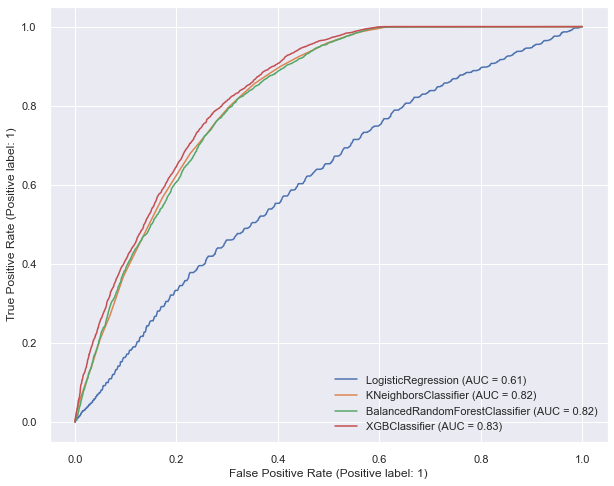

In [189]:
plot_roc_auc(models, X_test, y_test)